# weighted ego network clustering of different sizes

In [2]:
import pandas as pd
import scipy
import matplotlib
import matplotlib.colors as mcolors
import os 

import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import fcluster, to_tree, dendrogram, linkage
import glob
from scipy.spatial.distance import squareform
import numpy as np
import networkx as nx
from graspologic.match import graph_match
from sklearn import datasets, manifold
from matplotlib.pyplot import cm
import seaborn as sns
from adjustText import adjust_text
import scipy
from scipy import cluster


/Users/ssm47/opt/anaconda3/envs/thesis_env/lib/python3.9/site-packages/graspologic/layouts/colors.py:13: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/Users/ssm47/opt/anaconda3/envs/thesis_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from module.wegog_utils import get_ego_top_NM, prepare_nhood_graphs, perform_matching, matching_distance, df_to_graph
from module.utils import load_object

In [4]:
from module.dendrogram_utils import dendrogram_clustering
from module.gramchd.gmd import sort_adjacencies, distance_stats, perform_matching_distance, combine_vecs
from module.gramchd.nhood import get_io_top_NM, get_io_top_M
# from src.nhood_vis import df_to_graph
from module.gramchd.nhood_vis import plot_two_graphs_overlay, plot_two_graphs_from_output
from module.utils import get_neighbourhood, get_w_threshold

from module.denclex.dendrogram_eval import get_clustering_stats, cluster_purity_test

In [5]:
import pandas as pd

from module.denclex.dendrograms_plotting import get_network_from_tree, get_adj_from_edgelist, generate_cluster_evolution
from module.denclex.tree_network import tree_search



In [ ]:
datadate = '20231124'

nb_name = '01_weg_sizes'
save_things = False


In [7]:
vnc_edges = pd.read_csv(f'../../data/vnc/{datadate}_data/manc_edges_{datadate}.csv', index_col=0)

vnc_edges = vnc_edges.groupby(['bodyId_pre', 'bodyId_post'], as_index=False).weight.sum()
vnc_edges.rename(columns={'bodyId_pre':'pre', 'bodyId_post':'post'}, inplace=True)
vnc_meta = pd.read_csv(f'../../data/vnc/{datadate}_data/manc_meta_{datadate}.csv', index_col=0)
vnc_edges.loc[:,'attr'] = vnc_edges.weight.apply(lambda x: {'weight':x})
vnc_meta.bodyId = vnc_meta.bodyId.astype('str')


# open:

In [8]:
heminames = ['13B', '23B', '14A'] # sample hemilineages
n_ids = list(set(vnc_meta[(vnc_meta['hemilineage'].isin(heminames))].bodyId.values))
# n_ids = nexist_ids # all by all
n_ids = sorted(n_ids)[:]


In [9]:
len(n_ids)

1369

In [10]:

jobname = 'vnc_gmd_sample_hemi_job_M30_arr'

fpath_prefix = f'../../data/vnc/{datadate}_data/gmatching/{jobname}/array_*/{jobname}_*_combined.parquet'
files = glob.glob(fpath_prefix)
total_M30_vecs = combine_vecs(fpath_prefix)
total_M30_vecs = total_M30_vecs.drop_duplicates().sort_values(['id_1', 'id_2']).reset_index(drop=True)

# arr_no = 1
# jobno = 0
# data_dir = f'./data/vnc/{datadate}_data/gmatching/{jobname}/array_{arr_no}/{jobname}_{arr_no}_{jobno}.parquet'

# hemis_M30_ew_dist_itharr_jthjob_df = pd.read_parquet(data_dir)


# get nhoods:

In [11]:
M=50

In [12]:
# heminames = ['12A', '02A', '00A', '09B']

# heminames = ['12A', '06B', '00A', '09B']


heminames = ['13B', '23B', '14A'] # sample hemilineages


In [13]:


n_ids = list(set(vnc_meta[(vnc_meta['hemilineage'].isin(heminames))].bodyId.values)) # the integers have the numpy.int64 datatype!
n_ids = sorted([str(i) for i in n_ids])[:]
len(n_ids)

1369

In [14]:
n_ids_meta = vnc_meta[vnc_meta['bodyId'].isin(n_ids)].copy(True).set_index('bodyId')
n_ids_meta.index = n_ids_meta.index.astype('str')
n_ids_ptn = get_neighbourhood(Ids=n_ids, df=vnc_edges)
pp_set = set(n_ids_ptn[['pre', 'post']].to_numpy().flatten())
n_ids_nhood = vnc_edges[vnc_edges['post'].isin(pp_set) & vnc_edges['pre'].isin(pp_set)].sort_index().copy(True)
# n_ids_nhood.loc[:,'attr'] = n_ids_nhood.weight.apply(lambda x: {'weight':x})


In [15]:
hemi_graphs = prepare_nhood_graphs(all_ids=n_ids, df=n_ids_nhood, edge_number=None, node_number=M, directed=True)
print(len(hemi_graphs))

1369


# Prep stats:

In [16]:
# def get_io_top_M(Id, df, M):
#     '''Gets the dataframe with the top M neurons by weight, irrespective of in or out.'''
#     source, sink = df.columns[:2]

#     pre = df.query(f'{sink}==@Id')[[source, 'weight']]
#     # print(pre)
#     post = df.query(f'{source}==@Id')[[sink, 'weight']]
#     # print(post)
#     pre.set_index(source).sort_values('weight')
#     summed_prepost = post.join(pre.set_index(source), on=sink, lsuffix='_post', rsuffix='_pre', how='outer').fillna(0)#.sort_values('weight_pre', ascending=False)
#     summed_prepost.rename(columns={sink:'id'}, inplace=True)
#     summed_prepost['total_weight'] = summed_prepost['weight_post'] + summed_prepost['weight_pre']
#     return summed_prepost.sort_values('total_weight', ascending=False).iloc[:M]


## nhood 

In [17]:
partner_dfs = []
int_n_ids = [int(i) for i in n_ids]

normed_partner_cum_sum_dfs = []
partner_cum_sum_dfs = []

for i in int_n_ids:
    # print(i)
    partner_df = get_io_top_M(Id=i, df=get_w_threshold(vnc_edges, thrshld=0), M=None).reset_index(drop=True)
    partner_cum_sum_df = partner_df.iloc[:,1:].cumsum(axis='index')
    total_weights = partner_df.iloc[:, 1:].sum(axis=0).to_dict()
    normed_partner_cum_sum_df = partner_cum_sum_df.div(total_weights) # normalised by total
    partner_dfs.append(partner_df)
    partner_cum_sum_dfs.append(partner_cum_sum_df)
    normed_partner_cum_sum_dfs.append(normed_partner_cum_sum_df)

# 2mins 22 

In [18]:
nM_stats = {}

for M in [15, 30, 50, 80, 100]:
    M_id_dict = {}
    for ind, val in enumerate(int_n_ids):
        #     print(ind, val, M)
            _df = normed_partner_cum_sum_dfs[ind]
            ith_check = min(len(_df)-1, M-1)
            M_id_dict[val] = normed_partner_cum_sum_dfs[ind].loc[ith_check].to_dict()
    n_ids_M_cumweight_df = pd.DataFrame.from_dict(M_id_dict, orient='index')
    n_ids_M_cumweight_df.index = n_ids_M_cumweight_df.index.astype(str)

    nM_stats[M] = n_ids_M_cumweight_df

In [19]:


colors = [(0, 'red'), (0.5, 'white'), (1, 'green')]

# Create a colormap
wcmap = mcolors.LinearSegmentedColormap.from_list('custom_colormap', colors)

## hemilineage

In [20]:
hemi_ind = n_ids_meta.loc[n_ids]['hemilineage'].to_numpy()
hemi_uniques = list(set(hemi_ind))
numeric_hemi_data = np.zeros_like(hemi_ind, dtype=int)
for i, category in enumerate(hemi_uniques):
    numeric_hemi_data[hemi_ind == category] = i
cinds_avoid_rg = list(range(len(hemi_uniques)+2))[:2] + list(range(len(hemi_uniques)+2))[4:] 
colors = [cm.tab10.colors[cind] for cind in cinds_avoid_rg]

# Create a colormap from the colors
hemicmap = plt.matplotlib.colors.ListedColormap(colors)


# Load data:

## M = 15

In [21]:
# M=15

In [22]:
# hemis_M30_ew_dist_df = pd.read_parquet(f'./data/vnc/{datadate}_data/gmatching/vnc_ewg_gmd_sample_lowmem_M{M}_0_combined.parquet')

# hemis_M30_ew_dist_df = hemis_M30_ew_dist_df.sort_values(['id_1', 'id_2'], ascending=[True, True]).drop_duplicates().reset_index(drop=True)

In [23]:
# jobname = f'vnc_gmd_sample_hemi_job_M{M}_arr'

# fpath_prefix = f'../../data/vnc/{datadate}_data/gmatching/{jobname}/array_*/{jobname}_*_combined.parquet'
# files = glob.glob(fpath_prefix)
# hemis_M15_ew_dist_df = combine_vecs(fpath_prefix)
# hemis_M15_ew_dist_df = hemis_M15_ew_dist_df.drop_duplicates().sort_values(['id_1', 'id_2']).reset_index(drop=True)


## M=30

In [24]:
M=30

In [25]:
# hemis_M30_ew_dist_df = pd.read_parquet(f'./data/vnc/{datadate}_data/gmatching/vnc_ewg_gmd_sample_lowmem_M{M}_0_combined.parquet')

# hemis_M30_ew_dist_df = hemis_M30_ew_dist_df.sort_values(['id_1', 'id_2'], ascending=[True, True]).drop_duplicates().reset_index(drop=True)

In [26]:
jobname = f'vnc_gmd_sample_hemi_job_M{M}_arr'

fpath_prefix = f'../../data/vnc/{datadate}_data/gmatching/{jobname}/array_*/{jobname}_*_combined.parquet'
files = glob.glob(fpath_prefix)
hemis_M30_ew_dist_df = combine_vecs(fpath_prefix)
hemis_M30_ew_dist_df = hemis_M30_ew_dist_df.drop_duplicates().sort_values(['id_1', 'id_2']).reset_index(drop=True)


## M=50

In [27]:
M=50

In [28]:
# hemis_M50_ew_dist_df = pd.read_parquet(f'./data/vnc/{datadate}_data/gmatching/vnc_ewg_gmd_sample_lowmem_0_combined.parquet')

# hemis_M50_ew_dist_df = hemis_M50_ew_dist_df.sort_values(['id_1', 'id_2'], ascending=[True, True]).reset_index(drop=True)

In [29]:
jobname = 'vnc_gmd_sample_hemi_job_M50_arr'

fpath_prefix = f'../../data/vnc/{datadate}_data/gmatching/{jobname}/array_*/{jobname}_*_combined.parquet'
files = glob.glob(fpath_prefix)
hemis_M50_ew_dist_df = combine_vecs(fpath_prefix)
hemis_M50_ew_dist_df = hemis_M50_ew_dist_df.drop_duplicates().sort_values(['id_1', 'id_2']).reset_index(drop=True)


## M=80

In [30]:
M=80

In [31]:
# hemis_M80_ew_dist_df = pd.read_parquet(f'./data/vnc/{datadate}_data/gmatching/vnc_ewg_gmd_sample_lowmem_M{M}_0_combined.parquet')

# hemis_M80_ew_dist_df = hemis_M80_ew_dist_df.sort_values(['id_1', 'id_2'], ascending=[True, True]).drop_duplicates().reset_index(drop=True)

In [32]:
jobname = f'vnc_gmd_sample_hemi_job_M{M}_arr'

fpath_prefix = f'../../data/vnc/{datadate}_data/gmatching/{jobname}/array_*/{jobname}_*_combined.parquet'
files = glob.glob(fpath_prefix)
hemis_M80_ew_dist_df = combine_vecs(fpath_prefix)
hemis_M80_ew_dist_df = hemis_M80_ew_dist_df.drop_duplicates().sort_values(['id_1', 'id_2']).reset_index(drop=True)


## M=100

In [33]:
M=100

In [34]:
jobname = f'vnc_gmd_sample_hemi_job_M{M}_arr'

fpath_prefix = f'../../data/vnc/{datadate}_data/gmatching/{jobname}/array_*/{jobname}_*_combined.parquet'
files = glob.glob(fpath_prefix)
hemis_M100_ew_dist_df = combine_vecs(fpath_prefix)
hemis_M100_ew_dist_df = hemis_M100_ew_dist_df.drop_duplicates().sort_values(['id_1', 'id_2']).reset_index(drop=True)


# Clustering visualisation:

In [35]:
msize_dist_df = {30: hemis_M30_ew_dist_df, 50:hemis_M50_ew_dist_df, 80:hemis_M80_ew_dist_df, 100:hemis_M100_ew_dist_df}

## horizontal:

In [36]:
# M=15
# dist_df = msize_dist_df[M]

# dist_type = 'euclidean_distance'

# method='ward'

# cond_dist = (dist_df[dist_type].values)
# Z = linkage(cond_dist, method=method) ####### linkage

# ind_to_id = [str(i) for i in n_ids]
# title = f'{heminames}, M ={M}, {dist_type}, method={method}'

# N_type_data= 2

# hemi_ind = n_ids_meta.loc[n_ids]['hemilineage'].to_numpy()
# hemi_uniques = list(set(hemi_ind))
# numeric_hemi_data = np.zeros_like(hemi_ind, dtype=int)
# for i, category in enumerate(hemi_uniques):
#     numeric_hemi_data[hemi_ind == category] = i

# cinds_avoid_rg =list(range(len(hemi_uniques))) # list(range(len(hemi_uniques)+2))[:2] + list(range(len(hemi_uniques)+2))[4:]  # #
# colors = [cm.tab10.colors[cind] for cind in cinds_avoid_rg]

# # colors = ['blue', 'orange', 'pink']
# # Create a colormap from the colors
# hemicmap = plt.matplotlib.colors.ListedColormap(colors)

# # Plot the categorical data
# # method = 'ward'


# fig = plt.figure(figsize=(10, 3))
# fig.suptitle(f'weg clustering {heminames}, {M} neighbours', fontsize=16)

# gs0 = matplotlib.gridspec.GridSpec(2,1, figure=fig,
#                                    height_ratios=[10,5], hspace=0.05)
# gs1 = matplotlib.gridspec.GridSpecFromSubplotSpec(2,1, subplot_spec=gs0[0],
#                                                   height_ratios=[1,0],
#                                                   hspace=0)

# ax_col_dendrogram = fig.add_subplot(gs1[0])

# col_dendrogram = scipy.cluster.hierarchy.dendrogram(Z, ax=ax_col_dendrogram, color_threshold=0)
# ax_col_dendrogram.set_axis_off()

# xind = col_dendrogram['leaves']

# xmin,xmax = ax_col_dendrogram.get_xlim()

# gs2 = matplotlib.gridspec.GridSpecFromSubplotSpec(N_type_data, 1, subplot_spec=gs0[1])

# n_ids_cumweight_df = nM_stats[M]
# type_data=zip([numeric_hemi_data, n_ids_cumweight_df.total_weight.to_numpy()],[hemicmap, wcmap], ['hemilineage', 'total_weight']) 

# for i,(data,cmap, label) in enumerate(type_data):
#     ax = fig.add_subplot(gs2[i], sharex=ax_col_dendrogram)
#     ax.imshow(data[xind].reshape((1,-1)), aspect='auto', extent=[xmin,xmax,0,1], cmap=cmap)
#     ax.set_yticks([])
#     ax.set_ylabel(label, rotation=0, ha='right', va='center')
#     ax.set_xticks([])
#     plt.setp(ax.get_xticklabels(), visible=False)
# # plt.colorbar()
# # save=False
# if save_things:
#     plt.savefig(f'../figures/{datadate}/weg_hemisample_M{M}_topview.png', bbox_inches='tight', dpi=200, transparent=True)
# # save=False

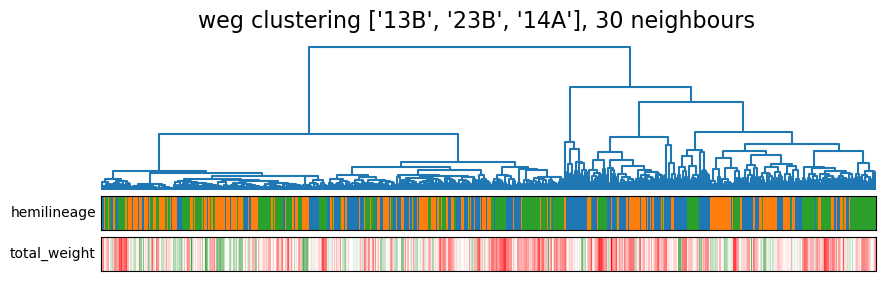

In [37]:
M=30
dist_df = msize_dist_df[M]

dist_type = 'euclidean_distance'

method='ward'

cond_dist = (dist_df[dist_type].values)
Z = linkage(cond_dist, method=method) ####### linkage

ind_to_id = [str(i) for i in n_ids]
title = f'{heminames}, M ={M}, {dist_type}, method={method}'

N_type_data= 2

hemi_ind = n_ids_meta.loc[n_ids]['hemilineage'].to_numpy()
hemi_uniques = list(set(hemi_ind))
numeric_hemi_data = np.zeros_like(hemi_ind, dtype=int)
for i, category in enumerate(hemi_uniques):
    numeric_hemi_data[hemi_ind == category] = i

cinds_avoid_rg =list(range(len(hemi_uniques))) # list(range(len(hemi_uniques)+2))[:2] + list(range(len(hemi_uniques)+2))[4:]  # #
colors = [cm.tab10.colors[cind] for cind in cinds_avoid_rg]

# colors = ['blue', 'orange', 'pink']
# Create a colormap from the colors
hemicmap = plt.matplotlib.colors.ListedColormap(colors)

# Plot the categorical data
# method = 'ward'


fig = plt.figure(figsize=(10, 3))
fig.suptitle(f'weg clustering {heminames}, {M} neighbours', fontsize=16)

gs0 = matplotlib.gridspec.GridSpec(2,1, figure=fig,
                                   height_ratios=[10,5], hspace=0.05)
gs1 = matplotlib.gridspec.GridSpecFromSubplotSpec(2,1, subplot_spec=gs0[0],
                                                  height_ratios=[1,0],
                                                  hspace=0)

ax_col_dendrogram = fig.add_subplot(gs1[0])

col_dendrogram = scipy.cluster.hierarchy.dendrogram(Z, ax=ax_col_dendrogram, color_threshold=0)
ax_col_dendrogram.set_axis_off()

xind = col_dendrogram['leaves']

xmin,xmax = ax_col_dendrogram.get_xlim()

gs2 = matplotlib.gridspec.GridSpecFromSubplotSpec(N_type_data, 1, subplot_spec=gs0[1])

n_ids_cumweight_df = nM_stats[M]
type_data=zip([numeric_hemi_data, n_ids_cumweight_df.total_weight.to_numpy()],[hemicmap, wcmap], ['hemilineage', 'total_weight']) 

for i,(data,cmap, label) in enumerate(type_data):
    ax = fig.add_subplot(gs2[i], sharex=ax_col_dendrogram)
    ax.imshow(data[xind].reshape((1,-1)), aspect='auto', extent=[xmin,xmax,0,1], cmap=cmap)
    ax.set_yticks([])
    ax.set_ylabel(label, rotation=0, ha='right', va='center')
    ax.set_xticks([])
    plt.setp(ax.get_xticklabels(), visible=False)
# save=False
if save_things:
    plt.savefig(f'../figures/{nb_name}/weg_hemisample_M{M}_topview.png', bbox_inches='tight', dpi=200, transparent=True)
# save=False

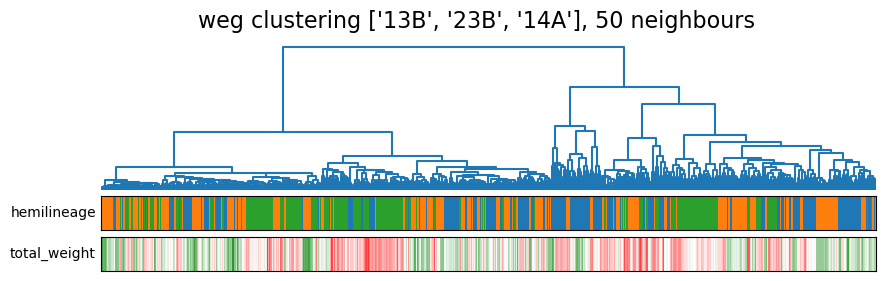

In [38]:
M=50
dist_df = msize_dist_df[M]

dist_type = 'euclidean_distance'

method='ward'

cond_dist = (dist_df[dist_type].values)
Z = linkage(cond_dist, method=method) ####### linkage

ind_to_id = [str(i) for i in n_ids]
title = f'{heminames}, M ={M}, {dist_type}, method={method}'

N_type_data= 2

hemi_ind = n_ids_meta.loc[n_ids]['hemilineage'].to_numpy()
hemi_uniques = list(set(hemi_ind))
numeric_hemi_data = np.zeros_like(hemi_ind, dtype=int)
for i, category in enumerate(hemi_uniques):
    numeric_hemi_data[hemi_ind == category] = i

cinds_avoid_rg =list(range(len(hemi_uniques))) # list(range(len(hemi_uniques)+2))[:2] + list(range(len(hemi_uniques)+2))[4:]  # #
colors = [cm.tab10.colors[cind] for cind in cinds_avoid_rg]

# colors = ['blue', 'orange', 'pink']
# Create a colormap from the colors
hemicmap = plt.matplotlib.colors.ListedColormap(colors)

# Plot the categorical data
# method = 'ward'


fig = plt.figure(figsize=(10, 3))
fig.suptitle(f'weg clustering {heminames}, {M} neighbours', fontsize=16)

gs0 = matplotlib.gridspec.GridSpec(2,1, figure=fig,
                                   height_ratios=[10,5], hspace=0.05)
gs1 = matplotlib.gridspec.GridSpecFromSubplotSpec(2,1, subplot_spec=gs0[0],
                                                  height_ratios=[1,0],
                                                  hspace=0)

ax_col_dendrogram = fig.add_subplot(gs1[0])

col_dendrogram = scipy.cluster.hierarchy.dendrogram(Z, ax=ax_col_dendrogram, color_threshold=0)
ax_col_dendrogram.set_axis_off()

xind = col_dendrogram['leaves']

xmin,xmax = ax_col_dendrogram.get_xlim()

gs2 = matplotlib.gridspec.GridSpecFromSubplotSpec(N_type_data, 1, subplot_spec=gs0[1])

n_ids_cumweight_df = nM_stats[M]
type_data=zip([numeric_hemi_data, n_ids_cumweight_df.total_weight.to_numpy()],[hemicmap, wcmap], ['hemilineage', 'total_weight']) 

for i,(data,cmap, label) in enumerate(type_data):
    ax = fig.add_subplot(gs2[i], sharex=ax_col_dendrogram)
    ax.imshow(data[xind].reshape((1,-1)), aspect='auto', extent=[xmin,xmax,0,1], cmap=cmap)
    ax.set_yticks([])
    ax.set_ylabel(label, rotation=0, ha='right', va='center')
    ax.set_xticks([])
    plt.setp(ax.get_xticklabels(), visible=False)
# save=False
if save_things:
    plt.savefig(f'../figures/{nb_name}/weg_hemisample_M{M}_topview.png', bbox_inches='tight', dpi=200, transparent=True)
# save=False

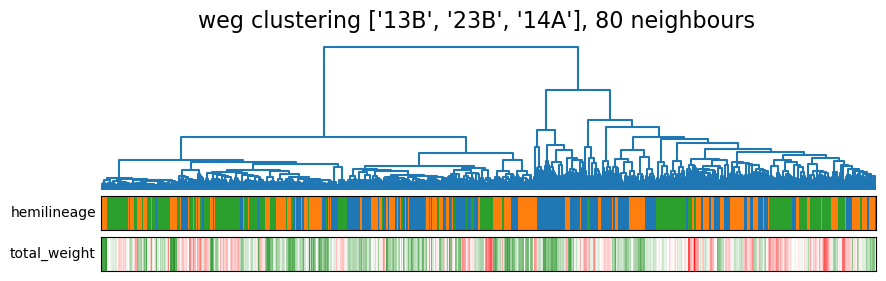

In [39]:
M=80
dist_df = msize_dist_df[M]

dist_type = 'euclidean_distance'

method='ward'

cond_dist = (dist_df[dist_type].values)
Z = linkage(cond_dist, method=method) ####### linkage

ind_to_id = [str(i) for i in n_ids]
title = f'{heminames}, M ={M}, {dist_type}, method={method}'

N_type_data= 2

hemi_ind = n_ids_meta.loc[n_ids]['hemilineage'].to_numpy()
hemi_uniques = list(set(hemi_ind))
numeric_hemi_data = np.zeros_like(hemi_ind, dtype=int)
for i, category in enumerate(hemi_uniques):
    numeric_hemi_data[hemi_ind == category] = i

cinds_avoid_rg =list(range(len(hemi_uniques))) # list(range(len(hemi_uniques)+2))[:2] + list(range(len(hemi_uniques)+2))[4:]  # #
colors = [cm.tab10.colors[cind] for cind in cinds_avoid_rg]

# colors = ['blue', 'orange', 'pink']
# Create a colormap from the colors
hemicmap = plt.matplotlib.colors.ListedColormap(colors)
# Plot the categorical data
# method = 'ward'


fig = plt.figure(figsize=(10, 3))
fig.suptitle(f'weg clustering {heminames}, {M} neighbours', fontsize=16)

gs0 = matplotlib.gridspec.GridSpec(2,1, figure=fig,
                                   height_ratios=[10,5], hspace=0.05)
gs1 = matplotlib.gridspec.GridSpecFromSubplotSpec(2,1, subplot_spec=gs0[0],
                                                  height_ratios=[1,0],
                                                  hspace=0)

ax_col_dendrogram = fig.add_subplot(gs1[0])

col_dendrogram = scipy.cluster.hierarchy.dendrogram(Z, ax=ax_col_dendrogram, color_threshold=0)
ax_col_dendrogram.set_axis_off()

xind = col_dendrogram['leaves']

xmin,xmax = ax_col_dendrogram.get_xlim()

gs2 = matplotlib.gridspec.GridSpecFromSubplotSpec(N_type_data, 1, subplot_spec=gs0[1])
n_ids_cumweight_df = nM_stats[M]


type_data=zip([numeric_hemi_data, n_ids_cumweight_df.total_weight.to_numpy()],[hemicmap, wcmap], ['hemilineage', 'total_weight']) 

for i,(data,cmap, label) in enumerate(type_data):
    ax = fig.add_subplot(gs2[i], sharex=ax_col_dendrogram)
    ax.imshow(data[xind].reshape((1,-1)), aspect='auto', extent=[xmin,xmax,0,1], cmap=cmap)
    ax.set_yticks([])
    ax.set_ylabel(label, rotation=0, ha='right', va='center')
    ax.set_xticks([])
    plt.setp(ax.get_xticklabels(), visible=False)
if save_things:
    plt.savefig(f'../figures/{nb_name}/weg_hemisample_M{M}_topview.png', bbox_inches='tight', dpi=200, transparent=True)


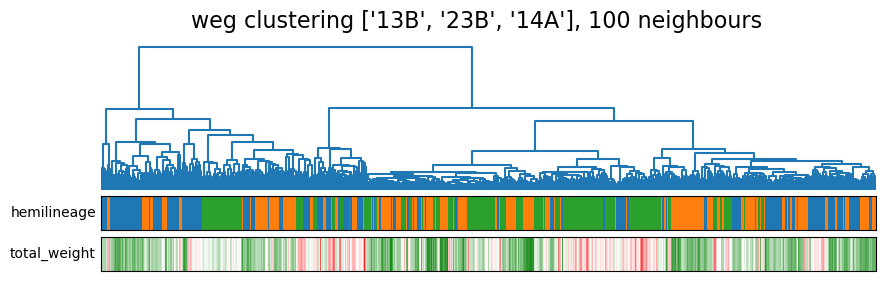

In [40]:
M=100
dist_df = msize_dist_df[M]

dist_type = 'euclidean_distance'

method='ward'

cond_dist = (dist_df[dist_type].values)
Z = linkage(cond_dist, method=method) ####### linkage

ind_to_id = [str(i) for i in n_ids]
title = f'{heminames}, M ={M}, {dist_type}, method={method}'

N_type_data= 2

hemi_ind = n_ids_meta.loc[n_ids]['hemilineage'].to_numpy()
hemi_uniques = list(set(hemi_ind))
numeric_hemi_data = np.zeros_like(hemi_ind, dtype=int)
for i, category in enumerate(hemi_uniques):
    numeric_hemi_data[hemi_ind == category] = i

cinds_avoid_rg =list(range(len(hemi_uniques))) # list(range(len(hemi_uniques)+2))[:2] + list(range(len(hemi_uniques)+2))[4:]  # #
colors = [cm.tab10.colors[cind] for cind in cinds_avoid_rg]

# colors = ['blue', 'orange', 'pink']
# Create a colormap from the colors
hemicmap = plt.matplotlib.colors.ListedColormap(colors)
# Plot the categorical data
# method = 'ward'


fig = plt.figure(figsize=(10, 3))
fig.suptitle(f'weg clustering {heminames}, {M} neighbours', fontsize=16)

gs0 = matplotlib.gridspec.GridSpec(2,1, figure=fig,
                                   height_ratios=[10,5], hspace=0.05)
gs1 = matplotlib.gridspec.GridSpecFromSubplotSpec(2,1, subplot_spec=gs0[0],
                                                  height_ratios=[1,0],
                                                  hspace=0)

ax_col_dendrogram = fig.add_subplot(gs1[0])

col_dendrogram = scipy.cluster.hierarchy.dendrogram(Z, ax=ax_col_dendrogram, color_threshold=0)
ax_col_dendrogram.set_axis_off()

xind = col_dendrogram['leaves']

xmin,xmax = ax_col_dendrogram.get_xlim()

gs2 = matplotlib.gridspec.GridSpecFromSubplotSpec(N_type_data, 1, subplot_spec=gs0[1])
n_ids_cumweight_df = nM_stats[M]


type_data=zip([numeric_hemi_data, n_ids_cumweight_df.total_weight.to_numpy()],[hemicmap, wcmap], ['hemilineage', 'total_weight']) 

for i,(data,cmap, label) in enumerate(type_data):
    ax = fig.add_subplot(gs2[i], sharex=ax_col_dendrogram)
    ax.imshow(data[xind].reshape((1,-1)), aspect='auto', extent=[xmin,xmax,0,1], cmap=cmap)
    ax.set_yticks([])
    ax.set_ylabel(label, rotation=0, ha='right', va='center')
    ax.set_xticks([])
    plt.setp(ax.get_xticklabels(), visible=False)
# save=True
if save_things:
    plt.savefig(f'../figures/{nb_name}/weg_hemisample_M{M}_topview.png', bbox_inches='tight', dpi=200, transparent=True)


In [41]:
ggg

NameError: name 'ggg' is not defined

# Dendrogram evaluation:

In [ ]:
ctype_to_hemi_dict = vnc_meta[vnc_meta.hemilineage.isin(heminames)][['type', 'hemilineage']].drop_duplicates().set_index('type')['hemilineage'].to_dict()

In [ ]:
hemitype_to_leaf = vnc_meta[vnc_meta['bodyId'].isin(ind_to_id)].groupby('hemilineage').bodyId.apply(list).to_dict()

## M=15

In [ ]:
M=15
dist_df = msize_dist_df[M]

dist_type = 'euclidean_distance'

method='ward'

cond_dist = (dist_df[dist_type].values)
Z = linkage(cond_dist, method=method) ####### linkage
ind_to_id = [str(i) for i in n_ids]


In [ ]:
ctype_to_leaf = vnc_meta[vnc_meta['bodyId'].isin(ind_to_id)].groupby('type').bodyId.apply(list).to_dict()

In [ ]:
# stats_df = get_clustering_stats(Z=Z, ctype_to_id=ctype_to_leaf, ind_to_id=ind_to_id)
fname = f'./data/vnc/{datadate}_data/gmatching/cluster_analysis/M{M}_hemisample_extrametrics.parquet'
# stats_df.to_parquet(fname)
# 58.3 seconds

In [ ]:
stats_df = pd.read_parquet(fname)

In [ ]:
stats_df

,labels,len,lps,mpd,pam,n_p,m_p,s_p
0,AN13B002,2,0.5,8.000000,0.033898,0,0,2
1,AN14A003,6,1.0,4.133333,1.000000,1,6,0
2,AN23B001,2,0.5,4.000000,0.500000,0,0,2
3,AN23B002,2,0.5,10.000000,0.033898,0,0,2
4,AN23B003,2,1.0,2.000000,1.000000,1,2,0
...,...,...,...,...,...,...,...,...
297,IN23B092,2,1.0,2.000000,1.000000,1,2,0
298,IN23B093,2,1.0,2.000000,1.000000,1,2,0
299,IN23B094,2,0.5,24.000000,0.001461,0,0,2
300,MNad07,4,1.0,3.166667,1.000000,1,4,0


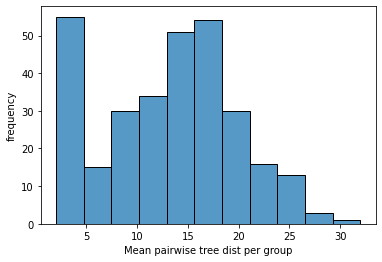

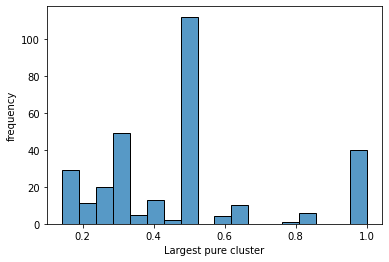

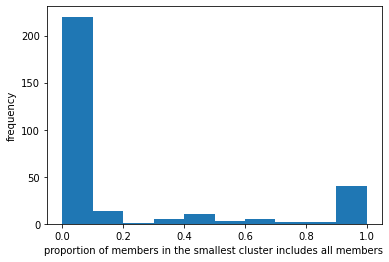

In [ ]:
# stats_df = get_clustering_stats(Z=Z, ctype_to_id=ctype_to_leaf, ind_to_id=ind_to_id)
sns.histplot(x=stats_df['mpd'])
plt.xlabel('Mean pairwise tree dist per group')
plt.ylabel('frequency')
plt.show()

sns.histplot(x=stats_df['lps'])
plt.xlabel('Largest pure cluster')
plt.ylabel('frequency')
plt.show()

plt.hist(x=stats_df['pam'])
plt.xlabel('proportion of members in the smallest cluster includes all members ')
plt.ylabel('frequency')
plt.show()

In [ ]:
stats_df['lps_frac'] =  (stats_df['len'] * stats_df['lps']).astype(int).astype(str)+ '/' + stats_df['len'].astype(int).astype(str) 

In [ ]:
stats_df[stats_df['lps']==1]

,labels,len,lps,mpd,pam,n_p,m_p,s_p,lps_frac
1,AN14A003,6,1.0,4.133333,1.0,1,6,0,6/6
4,AN23B003,2,1.0,2.000000,1.0,1,2,0,2/2
7,AN23B026,2,1.0,2.000000,1.0,1,2,0,2/2
8,IN13B001,6,1.0,4.133333,1.0,1,6,0,6/6
10,IN13B005,6,1.0,4.133333,1.0,1,6,0,6/6
13,IN13B008,2,1.0,2.000000,1.0,1,2,0,2/2
20,IN13B015,2,1.0,2.000000,1.0,1,2,0,2/2
23,IN13B019,6,1.0,4.200000,1.0,1,6,0,6/6
25,IN13B021,6,1.0,4.000000,1.0,1,6,0,6/6
53,IN13B051,2,1.0,2.000000,1.0,1,2,0,2/2


In [ ]:
# vnc_meta[vnc_meta.hemilineage.isin(heminames)][['type', 'hemilineage']].drop_duplicates()

In [ ]:
stats_df['hemi'] = stats_df.labels.apply(ctype_to_hemi_dict.get)

In [ ]:
lps_frac_freq = pd.DataFrame(stats_df['lps_frac'].value_counts()).reset_index()
lps_frac_freq['denom'] = lps_frac_freq['lps_frac'].apply(lambda x: int(x.split('/')[-1]))
lps_frac_freq['numer'] = lps_frac_freq['lps_frac'].apply(lambda x: int(x.split('/')[0]))


In [ ]:
col_dict = {'True': 'green', 'False':'red'}
lps_frac_freq['col'] = lps_frac_freq.apply(lambda x: col_dict.get(str(x.denom==x.numer)), axis=1)

In [ ]:
lps_frac_freq = lps_frac_freq.sort_values(['denom', 'lps_frac']).reset_index()

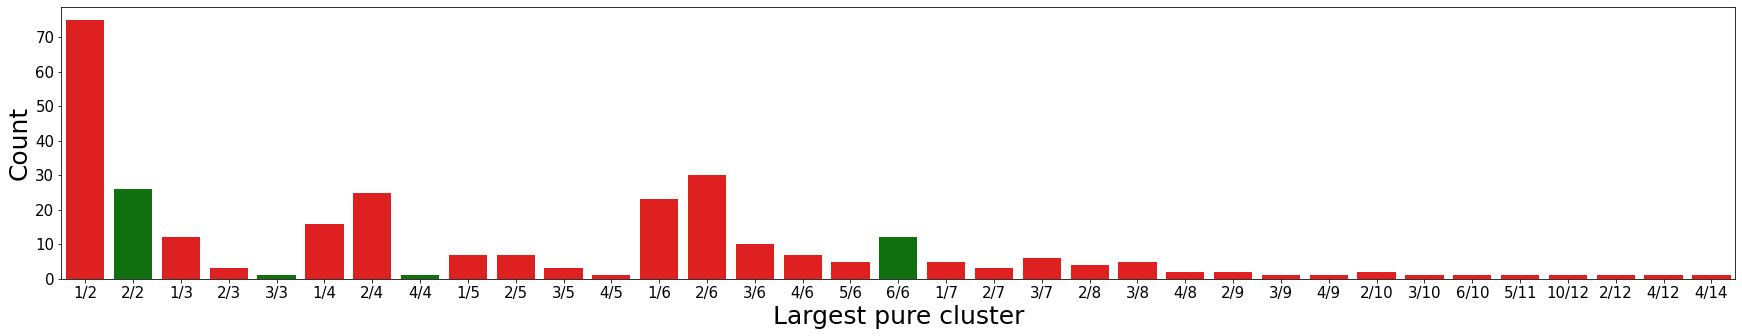

In [ ]:
plt.figure(figsize=(30, 5))

# cols = ['grey' if (x < max(lps_frac_freq.sales)) else 'orange' for x in lps_frac_freq.sales]
ax = sns.barplot(lps_frac_freq, x='lps_frac', y='count', estimator="sum", errorbar=None, palette=lps_frac_freq['col'] )
plt.xlabel('Largest pure cluster', size=25)
plt.ylabel('Count', size=25)
plt.xticks(size=15)
plt.yticks(size=15)
# save=False
# if save:
#     plt.savefig(f'./figs/2024/cccat_v_lpc_hist.png', bbox_inches='tight')
# save=False
# plt.grid()
plt.show()

In [ ]:
stats_df['lps_frac'] = pd.Categorical(stats_df['lps_frac'], lps_frac_freq.lps_frac.values)

In [ ]:
stats_df

,labels,len,lps,mpd,pam,n_p,m_p,s_p,lps_frac,hemi
0,AN13B002,2,0.5,8.000000,0.033898,0,0,2,1/2,13B
1,AN14A003,6,1.0,4.133333,1.000000,1,6,0,6/6,14A
2,AN23B001,2,0.5,4.000000,0.500000,0,0,2,1/2,23B
3,AN23B002,2,0.5,10.000000,0.033898,0,0,2,1/2,23B
4,AN23B003,2,1.0,2.000000,1.000000,1,2,0,2/2,23B
...,...,...,...,...,...,...,...,...,...,...
297,IN23B092,2,1.0,2.000000,1.000000,1,2,0,2/2,23B
298,IN23B093,2,1.0,2.000000,1.000000,1,2,0,2/2,23B
299,IN23B094,2,0.5,24.000000,0.001461,0,0,2,1/2,23B
300,MNad07,4,1.0,3.166667,1.000000,1,4,0,4/4,13B


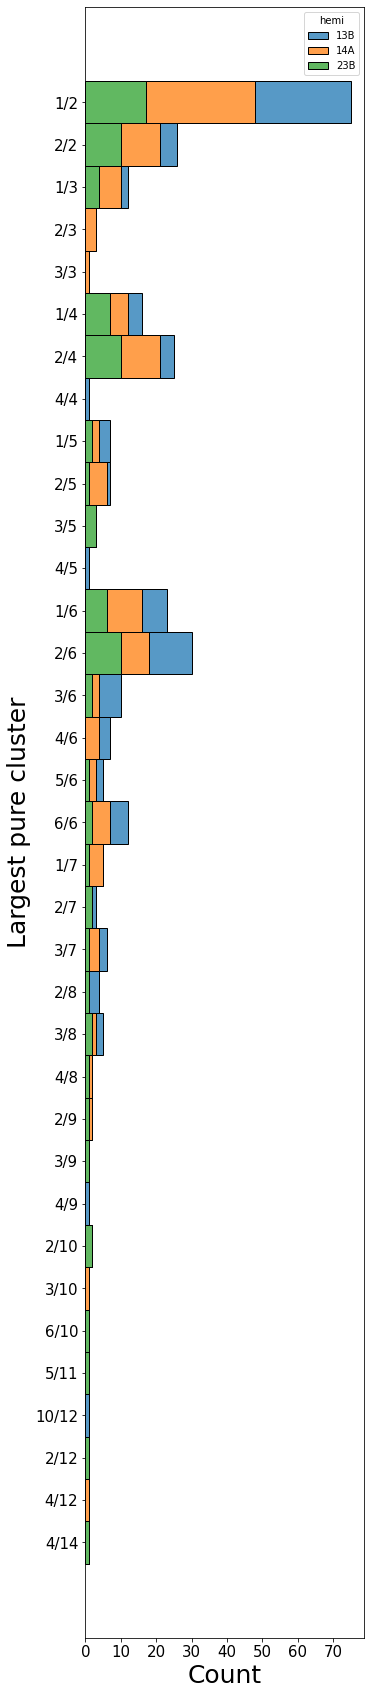

In [ ]:
plt.figure(figsize=(5, 30))

# cols = ['grey' if (x < max(lps_frac_freq.sales)) else 'orange' for x in lps_frac_freq.sales]
sns.histplot(stats_df, y='lps_frac', hue='hemi', multiple='stack')
plt.ylabel('Largest pure cluster', size=25)
plt.xlabel('Count', size=25)
plt.xticks(size=15)
plt.yticks(size=15)
# save=False
# if save:
#     plt.savefig(f'./figs/2024/cccat_v_lpc_hist.png', bbox_inches='tight')
# save=False
# plt.grid()
plt.show()

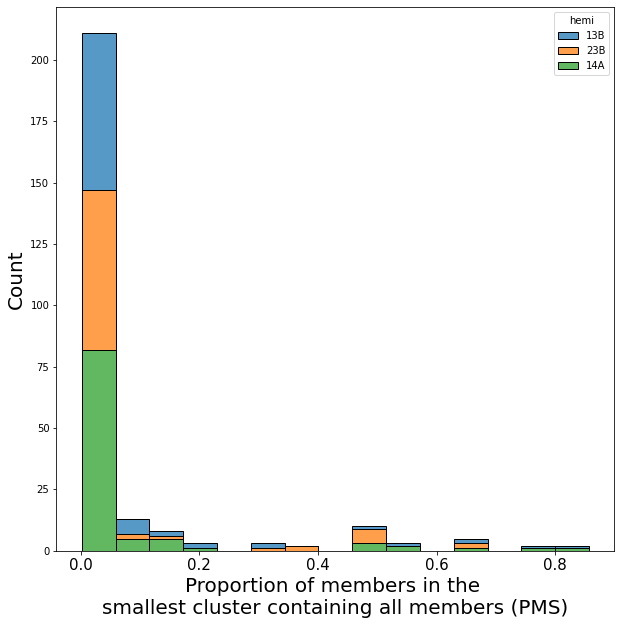

In [ ]:
plt.figure(figsize=(10,10))

sns.histplot(stats_df[stats_df['pam']<1], x='pam', bins=15, hue='hemi',multiple="stack")
plt.ylabel('Count', size=20)
# plt.yticks([0,5,10,15,20], size=15)
plt.xticks(size=15)
# plt.legend(title='Group size', fontsize=10)
plt.xlabel('Proportion of members in the \nsmallest cluster containing all members (PMS)', size=20)

plt.show()

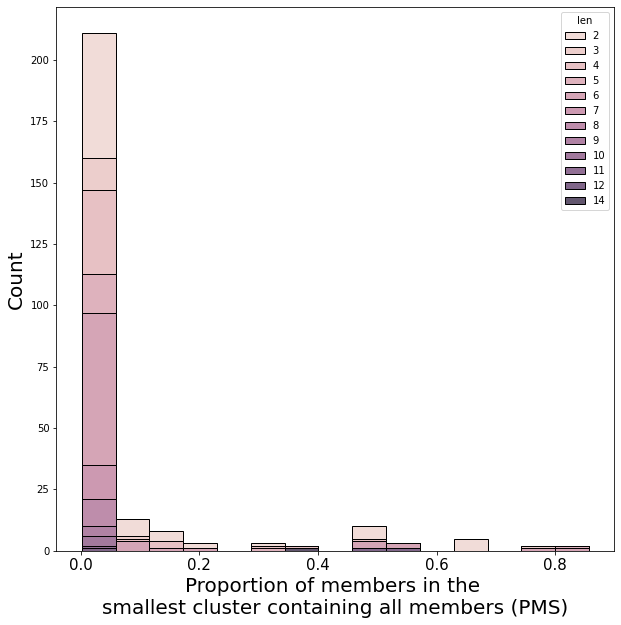

In [ ]:
plt.figure(figsize=(10,10))

sns.histplot(stats_df[stats_df['pam']<1], x='pam', bins=15, hue='len',multiple="stack")
plt.ylabel('Count', size=20)
# plt.yticks([0,5,10,15,20], size=15)
plt.xticks(size=15)
# plt.legend(title='Group size', fontsize=10)
plt.xlabel('Proportion of members in the \nsmallest cluster containing all members (PMS)', size=20)

plt.show()

In [ ]:

M15_pct_df= (stats_df[stats_df['lps']==1])
print('number of cell types perfectly clustered:', len(M15_pct_df))
print('number of neurons in perfect clusters:', M15_pct_df.len.sum())

number of cell types perfectly clustered: 40
number of neurons in perfect clusters: 131


In [ ]:
M15_rct_df = stats_df[(stats_df['lps']<1)&(stats_df['lps']>=0.5)&(stats_df['len']>2)]
print('number of cell types reasonably clustered:', len(M15_rct_df))
print('number of neurons in reasonable clusters 1>LPS>0.5:', M15_rct_df.len.sum())

number of cell types reasonably clustered: 58
number of neurons in reasonable clusters 1>LPS>0.5: 299


In [ ]:
M15_bct_df = stats_df[((stats_df['lps']<.5)&(stats_df['len']>2))|((stats_df['lps']==.5)&(stats_df['len']==2))]
print('number of cell types in bad clusters 0.5>LPS:', len(M15_bct_df))
print('number of neurons in bad clusters 0.5>LPS:', M15_bct_df.len.sum())

number of cell types in bad clusters 0.5>LPS: 204
number of neurons in bad clusters 0.5>LPS: 923


### clustering stats for hemilineages

In [ ]:
hemi_stat_dict = {}

for label in heminames:
    ids_to_inspect = hemitype_to_leaf[label]
    cl_purity = cluster_purity_test(targets=ids_to_inspect, Z=Z, ind_to_id=ind_to_id)

    largest_pure = max([len(j) for j in cl_purity])#/len(ids_to_inspect)
    # lps.append(largest_pure) 

    n_singletons = sum([len(i)==1 for i in cl_purity])
    n_non_singletons = len(cl_purity) - n_singletons
    n_non_singletons_members = len(ids_to_inspect) - n_singletons
    # print('number of singletons', n_singletons)
    # print('number non-singleton clusters', n_non_singletons)
    # print('number of neurons in non-singleton clusters', n_non_singletons_members)

    hemi_stat_dict[label] = {'n_s':n_singletons, 'm_p':n_non_singletons_members, 'n_p':n_non_singletons, 'lps':largest_pure}


hemi_stat_df = pd.DataFrame.from_dict(hemi_stat_dict, orient='index')

hemi_stat_df['av_size'] = hemi_stat_df['m_p']/hemi_stat_df['n_p']
hemi_stat_df['coverage'] = hemi_stat_df['m_p']/(hemi_stat_df['n_s'] + hemi_stat_df['m_p'])


In [ ]:
M15_hemipurity = hemi_stat_df.sort_values('coverage').sort_values('coverage')

In [ ]:
hemi_stat_df.m_p.sum() /(hemi_stat_df.m_p.sum() + hemi_stat_df.n_s.sum() )

0.8203067932797663

## M=30

In [ ]:
M=30
dist_df = msize_dist_df[M]

dist_type = 'euclidean_distance'

method='ward'

cond_dist = (dist_df[dist_type].values)
Z = linkage(cond_dist, method=method) ####### linkage
ind_to_id = [str(i) for i in n_ids]


In [ ]:
ctype_to_leaf = vnc_meta[vnc_meta['bodyId'].isin(ind_to_id)].groupby('type').bodyId.apply(list).to_dict()

In [ ]:
# stats_df = get_clustering_stats(Z=Z, ctype_to_id=ctype_to_leaf, ind_to_id=ind_to_id)
fname = f'./data/vnc/{datadate}_data/gmatching/cluster_analysis/M{M}_hemisample_extrametrics.parquet'
# stats_df.to_parquet(fname)
# 2mins 20
# 3mins 30

In [ ]:
stats_df = pd.read_parquet(fname)

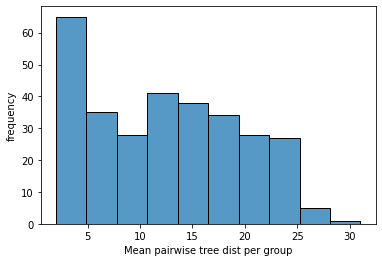

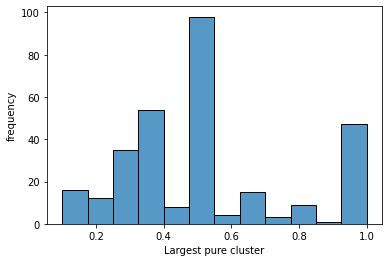

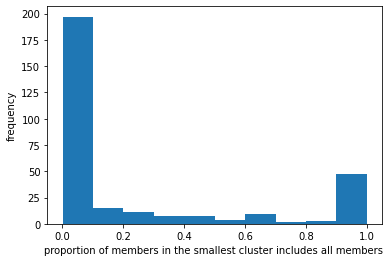

In [ ]:
# stats_df = get_clustering_stats(Z=Z, ctype_to_id=ctype_to_leaf, ind_to_id=ind_to_id)
sns.histplot(x=stats_df['mpd'])
plt.xlabel('Mean pairwise tree dist per group')
plt.ylabel('frequency')
plt.show()

sns.histplot(x=stats_df['lps'])
plt.xlabel('Largest pure cluster')
plt.ylabel('frequency')
plt.show()

plt.hist(x=stats_df['pam'])
plt.xlabel('proportion of members in the smallest cluster includes all members ')
plt.ylabel('frequency')
plt.show()

In [ ]:
stats_df['lps_frac'] =  (stats_df['len'] * stats_df['lps']).astype(int).astype(str)+ '/' + stats_df['len'].astype(int).astype(str) 

In [ ]:
stats_df[stats_df['lps']==1]

,labels,len,lps,mpd,pam,n_p,m_p,s_p,lps_frac,hemi
0,AN13B002,2,1.0,2.000000,1.0,1,2,0,2/2,13B
1,AN14A003,6,1.0,4.000000,1.0,1,6,0,6/6,14A
2,AN23B001,2,1.0,2.000000,1.0,1,2,0,2/2,23B
4,AN23B003,2,1.0,2.000000,1.0,1,2,0,2/2,23B
5,AN23B004,2,1.0,2.000000,1.0,1,2,0,2/2,23B
6,AN23B010,2,1.0,2.000000,1.0,1,2,0,2/2,23B
8,IN13B001,6,1.0,4.000000,1.0,1,6,0,6/6,13B
9,IN13B004,6,1.0,4.133333,1.0,1,6,0,6/6,13B
10,IN13B005,6,1.0,4.133333,1.0,1,6,0,6/6,13B
13,IN13B008,2,1.0,2.000000,1.0,1,2,0,2/2,13B


In [ ]:
# vnc_meta[vnc_meta.hemilineage.isin(heminames)][['type', 'hemilineage']].drop_duplicates()

In [ ]:
stats_df['hemi'] = stats_df.labels.apply(ctype_to_hemi_dict.get)

In [ ]:
lps_frac_freq = pd.DataFrame(stats_df['lps_frac'].value_counts()).reset_index()
lps_frac_freq['denom'] = lps_frac_freq['lps_frac'].apply(lambda x: int(x.split('/')[-1]))
lps_frac_freq['numer'] = lps_frac_freq['lps_frac'].apply(lambda x: int(x.split('/')[0]))

In [ ]:
col_dict = {'True': 'green', 'False':'red'}
lps_frac_freq['col'] = lps_frac_freq.apply(lambda x: col_dict.get(str(x.denom==x.numer)), axis=1)

In [ ]:
lps_frac_freq = lps_frac_freq.sort_values(['denom', 'lps_frac']).reset_index()

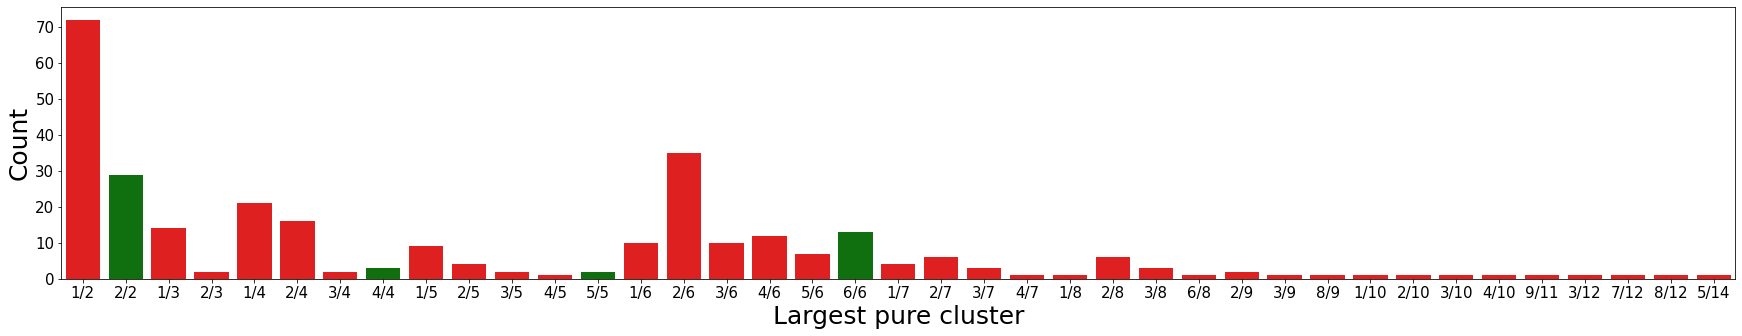

In [ ]:
plt.figure(figsize=(30, 5))

# cols = ['grey' if (x < max(lps_frac_freq.sales)) else 'orange' for x in lps_frac_freq.sales]
ax = sns.barplot(lps_frac_freq, x='lps_frac', y='count', estimator="sum", errorbar=None, palette=lps_frac_freq['col'] )
plt.xlabel('Largest pure cluster', size=25)
plt.ylabel('Count', size=25)
plt.xticks(size=15)
plt.yticks(size=15)
# save=False
# if save:
#     plt.savefig(f'./figs/2024/cccat_v_lpc_hist.png', bbox_inches='tight')
# save=False
# plt.grid()
plt.show()

In [ ]:
stats_df['lps_frac'] = pd.Categorical(stats_df['lps_frac'], lps_frac_freq.lps_frac.values)

In [ ]:
stats_df

,labels,len,lps,mpd,pam,n_p,m_p,s_p,lps_frac,hemi
0,AN13B002,2,1.0,2.000000,1.000000,1,2,0,2/2,13B
1,AN14A003,6,1.0,4.000000,1.000000,1,6,0,6/6,14A
2,AN23B001,2,1.0,2.000000,1.000000,1,2,0,2/2,23B
3,AN23B002,2,0.5,6.000000,0.222222,0,0,2,1/2,23B
4,AN23B003,2,1.0,2.000000,1.000000,1,2,0,2/2,23B
...,...,...,...,...,...,...,...,...,...,...
297,IN23B092,2,1.0,2.000000,1.000000,1,2,0,2/2,23B
298,IN23B093,2,0.5,3.000000,0.666667,0,0,2,1/2,23B
299,IN23B094,2,0.5,24.000000,0.001461,0,0,2,1/2,23B
300,MNad07,4,1.0,3.166667,1.000000,1,4,0,4/4,13B


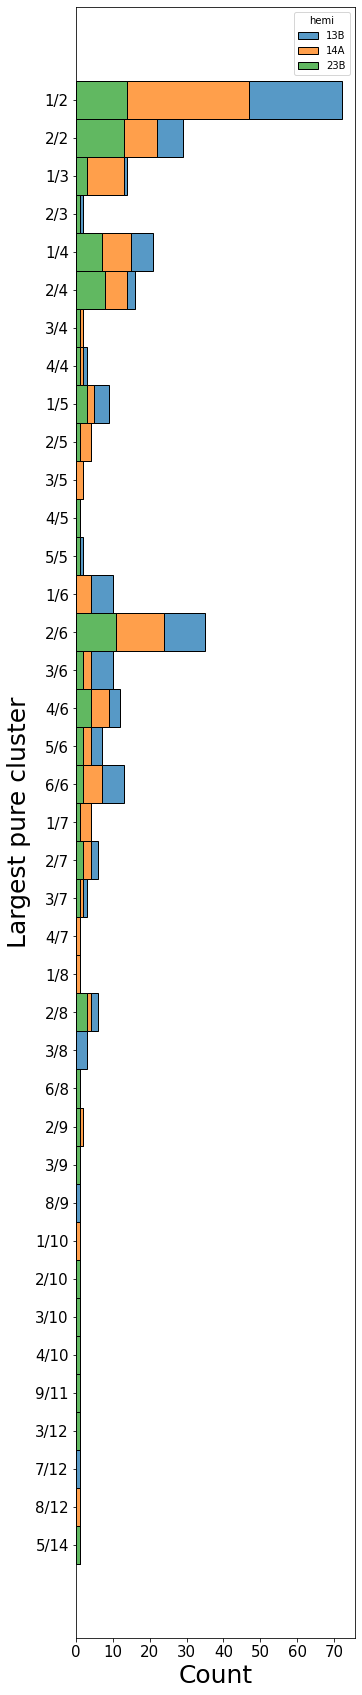

In [ ]:
plt.figure(figsize=(5, 30))

# cols = ['grey' if (x < max(lps_frac_freq.sales)) else 'orange' for x in lps_frac_freq.sales]
sns.histplot(stats_df, y='lps_frac', hue='hemi', multiple='stack')
plt.ylabel('Largest pure cluster', size=25)
plt.xlabel('Count', size=25)
plt.xticks(size=15)
plt.yticks(size=15)
# save=False
# if save:
#     plt.savefig(f'./figs/2024/cccat_v_lpc_hist.png', bbox_inches='tight')
# save=False
# plt.grid()
plt.show()

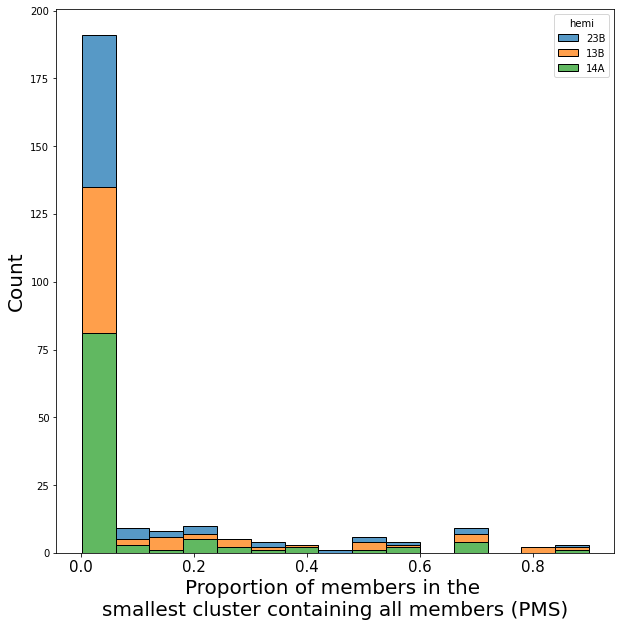

In [ ]:
plt.figure(figsize=(10,10))

sns.histplot(stats_df[stats_df['pam']<1], x='pam', bins=15, hue='hemi',multiple="stack")
plt.ylabel('Count', size=20)
# plt.yticks([0,5,10,15,20], size=15)
plt.xticks(size=15)
# plt.legend(title='Group size', fontsize=10)
plt.xlabel('Proportion of members in the \nsmallest cluster containing all members (PMS)', size=20)

plt.show()

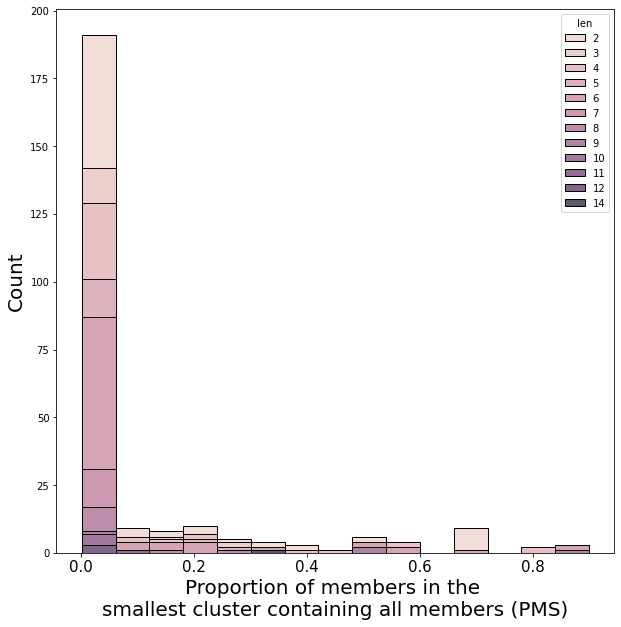

In [ ]:
plt.figure(figsize=(10,10))

sns.histplot(stats_df[stats_df['pam']<1], x='pam', bins=15, hue='len',multiple="stack")
plt.ylabel('Count', size=20)
# plt.yticks([0,5,10,15,20], size=15)
plt.xticks(size=15)
# plt.legend(title='Group size', fontsize=10)
plt.xlabel('Proportion of members in the \nsmallest cluster containing all members (PMS)', size=20)

plt.show()

In [ ]:
M30_pct_df= (stats_df[stats_df['lps']==1])
print('number of cell types perfectly clustered:', len(M30_pct_df))
print('number of neurons in perfect clusters:', M30_pct_df.len.sum())

number of cell types perfectly clustered: 47
number of neurons in perfect clusters: 158


In [ ]:
M30_rct_df = stats_df[(stats_df['lps']<1)&(stats_df['lps']>=0.5)&(stats_df['len']>2)]
print('number of cell types reasonably clustered:', len(M30_rct_df))
print('number of neurons in reasonable clusters 1>LPS>0.5:', M30_rct_df.len.sum())

number of cell types reasonably clustered: 58
number of neurons in reasonable clusters 1>LPS>0.5: 326


In [ ]:
M30_bct_df = stats_df[((stats_df['lps']<.5)&(stats_df['len']>2))|((stats_df['lps']==.5)&(stats_df['len']==2))]
print('number of cell types in bad clusters 0.5>LPS:', len(M30_bct_df))
print('number of neurons in bad clusters 0.5>LPS:', M30_bct_df.len.sum())

number of cell types in bad clusters 0.5>LPS: 197
number of neurons in bad clusters 0.5>LPS: 869


### Clustering stats for hemilineages:

In [ ]:
# hemitype_to_leaf = vnc_meta[vnc_meta['bodyId'].isin(ind_to_id)].groupby('hemilineage').bodyId.apply(list).to_dict()

In [ ]:
hemi_stat_dict = {}

for label in heminames:
    ids_to_inspect = hemitype_to_leaf[label]
    cl_purity = cluster_purity_test(targets=ids_to_inspect, Z=Z, ind_to_id=ind_to_id)

    largest_pure = max([len(j) for j in cl_purity])#/len(ids_to_inspect)
    # lps.append(largest_pure) 

    n_singletons = sum([len(i)==1 for i in cl_purity])
    n_non_singletons = len(cl_purity) - n_singletons
    n_non_singletons_members = len(ids_to_inspect) - n_singletons
    # print('number of singletons', n_singletons)
    # print('number non-singleton clusters', n_non_singletons)
    # print('number of neurons in non-singleton clusters', n_non_singletons_members)

    hemi_stat_dict[label] = {'n_s':n_singletons, 'm_p':n_non_singletons_members, 'n_p':n_non_singletons, 'lps':largest_pure}


In [ ]:
hemi_stat_df = pd.DataFrame.from_dict(hemi_stat_dict, orient='index')

hemi_stat_df['av_size'] = hemi_stat_df['m_p']/hemi_stat_df['n_p']
hemi_stat_df['coverage'] = hemi_stat_df['m_p']/(hemi_stat_df['n_s'] + hemi_stat_df['m_p'])


In [ ]:
M30_hemipurity = hemi_stat_df.sort_values('coverage').sort_values('coverage')

In [ ]:
M30_hemipurity

,n_s,m_p,n_p,lps,av_size,coverage
13B,62,368,78,19,4.717949,0.855814
14A,71,429,109,20,3.935780,0.858000
23B,44,395,65,39,6.076923,0.899772


In [ ]:
hemi_stat_df.m_p.sum() /(hemi_stat_df.m_p.sum() + hemi_stat_df.n_s.sum() )

0.870708546384222

## M=50

In [ ]:
M=50
dist_df = msize_dist_df[M]

dist_type = 'euclidean_distance'

method='ward'

cond_dist = (dist_df[dist_type].values)
Z = linkage(cond_dist, method=method) ####### linkage
ind_to_id = [str(i) for i in n_ids]


In [ ]:
ctype_to_leaf = vnc_meta[vnc_meta['bodyId'].isin(ind_to_id)].groupby('type').bodyId.apply(list).to_dict()

In [ ]:
# stats_df = get_clustering_stats(Z=Z, ctype_to_id=ctype_to_leaf, ind_to_id=ind_to_id)
fname = f'./data/vnc/{datadate}_data/gmatching/cluster_analysis/M{M}_hemisample_extrametrics.parquet'
# stats_df.to_parquet(fname)


In [ ]:
stats_df = pd.read_parquet(fname)

In [ ]:
stats_df

,labels,len,lps,mpd,pam,n_p,m_p,s_p
0,AN13B002,2,1.00,2.000000,1.000000,1,2,0
1,AN14A003,6,1.00,4.266667,1.000000,1,6,0
2,AN23B001,2,1.00,2.000000,1.000000,1,2,0
3,AN23B002,2,0.50,18.000000,0.004107,0,0,2
4,AN23B003,2,1.00,2.000000,1.000000,1,2,0
...,...,...,...,...,...,...,...,...
297,IN23B092,2,0.50,4.000000,0.500000,0,0,2
298,IN23B093,2,0.50,21.000000,0.005510,0,0,2
299,IN23B094,2,0.50,23.000000,0.002516,0,0,2
300,MNad07,4,0.75,15.166667,0.005031,1,3,1


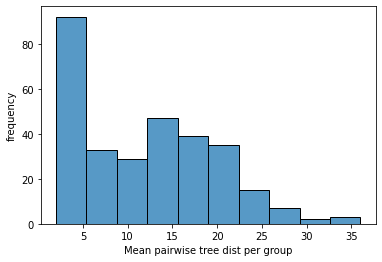

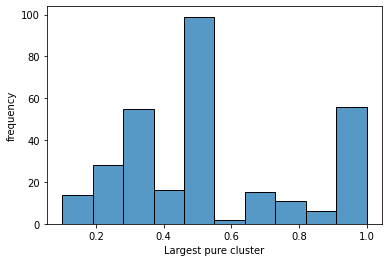

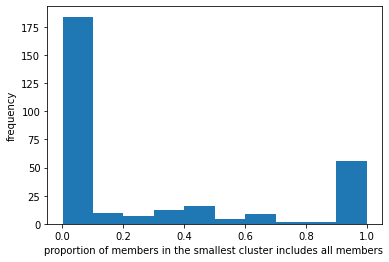

In [ ]:
# stats_df = get_clustering_stats(Z=Z, ctype_to_id=ctype_to_leaf, ind_to_id=ind_to_id)
sns.histplot(x=stats_df['mpd'])
plt.xlabel('Mean pairwise tree dist per group')
plt.ylabel('frequency')
plt.show()

sns.histplot(x=stats_df['lps'])
plt.xlabel('Largest pure cluster')
plt.ylabel('frequency')
plt.show()

plt.hist(x=stats_df['pam'])
plt.xlabel('proportion of members in the smallest cluster includes all members ')
plt.ylabel('frequency')
plt.show()

In [ ]:
stats_df['lps_frac'] =  (stats_df['len'] * stats_df['lps']).astype(int).astype(str)+ '/' + stats_df['len'].astype(int).astype(str) 

In [ ]:
stats_df[stats_df['lps']==1]

,labels,len,lps,mpd,pam,n_p,m_p,s_p,lps_frac
0,AN13B002,2,1.0,2.000000,1.0,1,2,0,2/2
1,AN14A003,6,1.0,4.266667,1.0,1,6,0,6/6
2,AN23B001,2,1.0,2.000000,1.0,1,2,0,2/2
4,AN23B003,2,1.0,2.000000,1.0,1,2,0,2/2
5,AN23B004,2,1.0,2.000000,1.0,1,2,0,2/2
6,AN23B010,2,1.0,2.000000,1.0,1,2,0,2/2
7,AN23B026,2,1.0,2.000000,1.0,1,2,0,2/2
8,IN13B001,6,1.0,4.133333,1.0,1,6,0,6/6
9,IN13B004,6,1.0,4.200000,1.0,1,6,0,6/6
10,IN13B005,6,1.0,4.133333,1.0,1,6,0,6/6


In [ ]:
# vnc_meta[vnc_meta.hemilineage.isin(heminames)][['type', 'hemilineage']].drop_duplicates()

In [ ]:
stats_df['hemi'] = stats_df.labels.apply(ctype_to_hemi_dict.get)

In [ ]:
lps_frac_freq = pd.DataFrame(stats_df['lps_frac'].value_counts()).reset_index()
lps_frac_freq['denom'] = lps_frac_freq['lps_frac'].apply(lambda x: int(x.split('/')[-1]))
lps_frac_freq['numer'] = lps_frac_freq['lps_frac'].apply(lambda x: int(x.split('/')[0]))


In [ ]:
col_dict = {'True': 'green', 'False':'red'}
lps_frac_freq['col'] = lps_frac_freq.apply(lambda x: col_dict.get(str(x.denom==x.numer)), axis=1)

In [ ]:
lps_frac_freq = lps_frac_freq.sort_values(['denom', 'lps_frac']).reset_index()

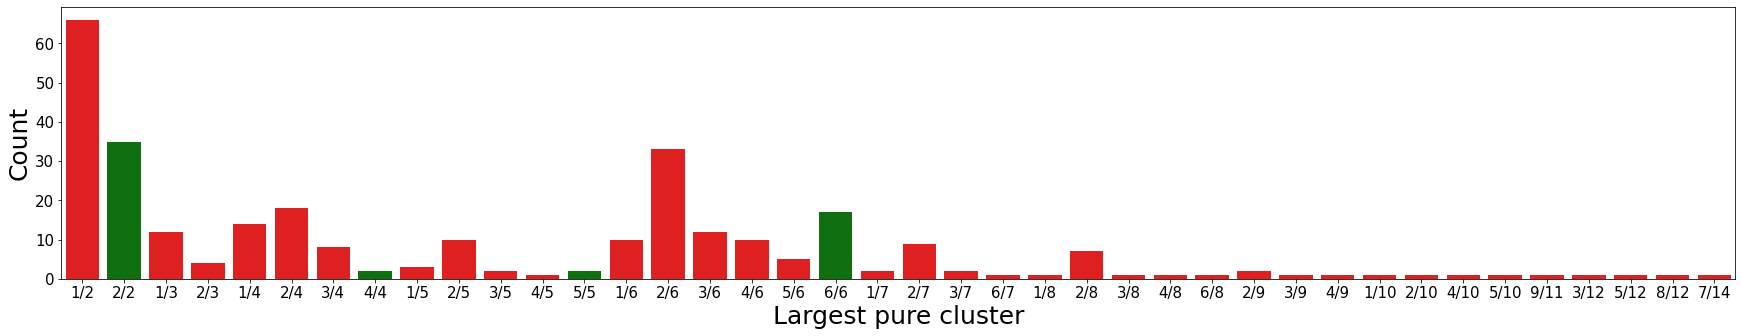

In [ ]:
plt.figure(figsize=(30, 5))

# cols = ['grey' if (x < max(lps_frac_freq.sales)) else 'orange' for x in lps_frac_freq.sales]
ax = sns.barplot(lps_frac_freq, x='lps_frac', y='count', estimator="sum", errorbar=None, palette=lps_frac_freq['col'] )
plt.xlabel('Largest pure cluster', size=25)
plt.ylabel('Count', size=25)
plt.xticks(size=15)
plt.yticks(size=15)
# save=False
# if save:
#     plt.savefig(f'./figs/2024/cccat_v_lpc_hist.png', bbox_inches='tight')
# save=False
# plt.grid()
plt.show()

In [ ]:
stats_df['lps_frac'] = pd.Categorical(stats_df['lps_frac'], lps_frac_freq.lps_frac.values)

In [ ]:
stats_df

,labels,len,lps,mpd,pam,n_p,m_p,s_p,lps_frac,hemi
0,AN13B002,2,1.00,2.000000,1.000000,1,2,0,2/2,13B
1,AN14A003,6,1.00,4.266667,1.000000,1,6,0,6/6,14A
2,AN23B001,2,1.00,2.000000,1.000000,1,2,0,2/2,23B
3,AN23B002,2,0.50,18.000000,0.004107,0,0,2,1/2,23B
4,AN23B003,2,1.00,2.000000,1.000000,1,2,0,2/2,23B
...,...,...,...,...,...,...,...,...,...,...
297,IN23B092,2,0.50,4.000000,0.500000,0,0,2,1/2,23B
298,IN23B093,2,0.50,21.000000,0.005510,0,0,2,1/2,23B
299,IN23B094,2,0.50,23.000000,0.002516,0,0,2,1/2,23B
300,MNad07,4,0.75,15.166667,0.005031,1,3,1,3/4,13B


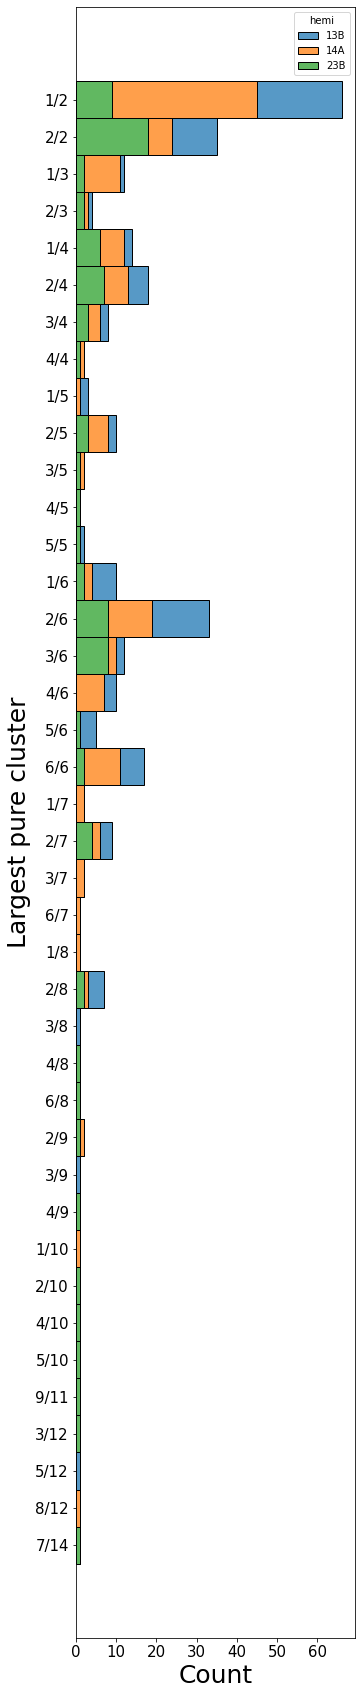

In [ ]:
plt.figure(figsize=(5, 30))

# cols = ['grey' if (x < max(lps_frac_freq.sales)) else 'orange' for x in lps_frac_freq.sales]
sns.histplot(stats_df, y='lps_frac', hue='hemi', multiple='stack')
plt.ylabel('Largest pure cluster', size=25)
plt.xlabel('Count', size=25)
plt.xticks(size=15)
plt.yticks(size=15)
# save=False
# if save:
#     plt.savefig(f'./figs/2024/cccat_v_lpc_hist.png', bbox_inches='tight')
# save=False
# plt.grid()
plt.show()

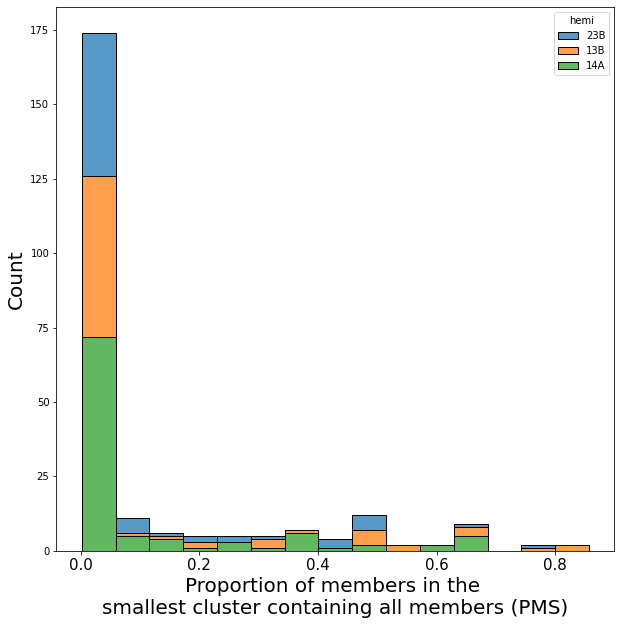

In [ ]:
plt.figure(figsize=(10,10))

sns.histplot(stats_df[stats_df['pam']<1], x='pam', bins=15, hue='hemi',multiple="stack")
plt.ylabel('Count', size=20)
# plt.yticks([0,5,10,15,20], size=15)
plt.xticks(size=15)
# plt.legend(title='Group size', fontsize=10)
plt.xlabel('Proportion of members in the \nsmallest cluster containing all members (PMS)', size=20)

plt.show()

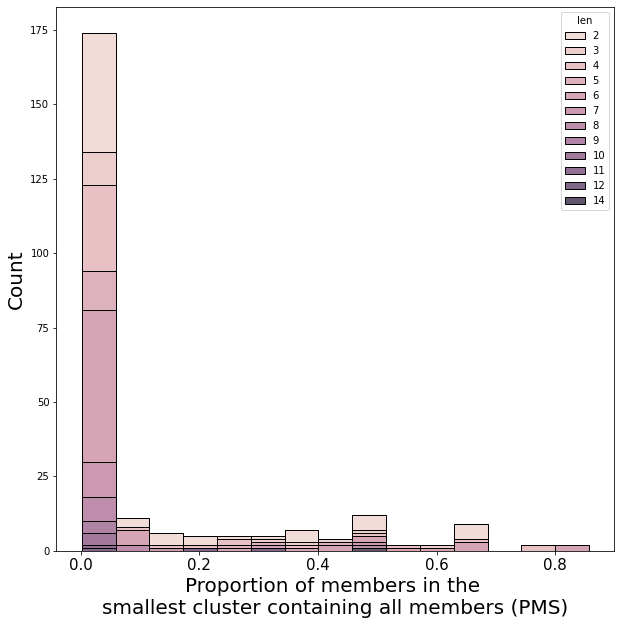

In [ ]:
plt.figure(figsize=(10,10))

sns.histplot(stats_df[stats_df['pam']<1], x='pam', bins=15, hue='len',multiple="stack")
plt.ylabel('Count', size=20)
# plt.yticks([0,5,10,15,20], size=15)
plt.xticks(size=15)
# plt.legend(title='Group size', fontsize=10)
plt.xlabel('Proportion of members in the \nsmallest cluster containing all members (PMS)', size=20)

plt.show()

In [ ]:

M50_pct_df= (stats_df[stats_df['lps']==1])
print('number of cell types perfectly clustered:', len(M50_pct_df))
print('number of neurons in perfect clusters:', M50_pct_df.len.sum())

number of cell types perfectly clustered: 56
number of neurons in perfect clusters: 190


In [ ]:
M50_rct_df = stats_df[(stats_df['lps']<1)&(stats_df['lps']>=0.5)&(stats_df['len']>2)]
print('number of cell types reasonably clustered:', len(M50_rct_df))
print('number of neurons in reasonable clusters 1>LPS>0.5:', M50_rct_df.len.sum())

number of cell types reasonably clustered: 67
number of neurons in reasonable clusters 1>LPS>0.5: 363


In [ ]:
M50_bct_df = stats_df[((stats_df['lps']<.5)&(stats_df['len']>2))|((stats_df['lps']==.5)&(stats_df['len']==2))]
print('number of cell types in bad clusters 0.5>LPS:', len(M50_bct_df))
print('number of neurons in bad clusters 0.5>LPS:', M50_bct_df.len.sum())

number of cell types in bad clusters 0.5>LPS: 179
number of neurons in bad clusters 0.5>LPS: 800


### clustering stats for hemilineages

In [ ]:
hemi_stat_dict = {}

for label in heminames:
    ids_to_inspect = hemitype_to_leaf[label]
    cl_purity = cluster_purity_test(targets=ids_to_inspect, Z=Z, ind_to_id=ind_to_id)

    largest_pure = max([len(j) for j in cl_purity])#/len(ids_to_inspect)
    # lps.append(largest_pure) 

    n_singletons = sum([len(i)==1 for i in cl_purity])
    n_non_singletons = len(cl_purity) - n_singletons
    n_non_singletons_members = len(ids_to_inspect) - n_singletons
    # print('number of singletons', n_singletons)
    # print('number non-singleton clusters', n_non_singletons)
    # print('number of neurons in non-singleton clusters', n_non_singletons_members)

    hemi_stat_dict[label] = {'n_s':n_singletons, 'm_p':n_non_singletons_members, 'n_p':n_non_singletons, 'lps':largest_pure}


hemi_stat_df = pd.DataFrame.from_dict(hemi_stat_dict, orient='index')

hemi_stat_df['av_size'] = hemi_stat_df['m_p']/hemi_stat_df['n_p']
hemi_stat_df['coverage'] = hemi_stat_df['m_p']/(hemi_stat_df['n_s'] + hemi_stat_df['m_p'])


In [ ]:
M50_hemipurity = hemi_stat_df.sort_values('coverage').sort_values('coverage')

In [ ]:
M50_hemipurity

,n_s,m_p,n_p,lps,av_size,coverage
13B,49,381,72,27,5.291667,0.886047
14A,55,445,95,22,4.684211,0.890000
23B,40,399,64,29,6.234375,0.908884


In [ ]:
hemi_stat_df.m_p.sum() /(hemi_stat_df.m_p.sum() + hemi_stat_df.n_s.sum() )

0.8948137326515705

## M=80

In [ ]:
M=80
dist_df = msize_dist_df[M]

dist_type = 'euclidean_distance'

method='ward'

cond_dist = (dist_df[dist_type].values)
Z = linkage(cond_dist, method=method) ####### linkage
ind_to_id = [str(i) for i in n_ids]


In [ ]:
ctype_to_leaf = vnc_meta[vnc_meta['bodyId'].isin(ind_to_id)].groupby('type').bodyId.apply(list).to_dict()

In [ ]:
# stats_df = get_clustering_stats(Z=Z, ctype_to_id=ctype_to_leaf, ind_to_id=ind_to_id)
fname = f'./data/vnc/{datadate}_data/gmatching/cluster_analysis/M{M}_hemisample_extrametrics.parquet'
# stats_df.to_parquet(fname)
# 2mins 20
# 3mins 30

In [ ]:
stats_df = pd.read_parquet(fname)

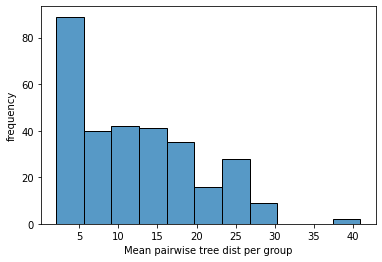

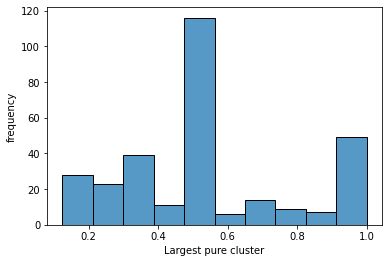

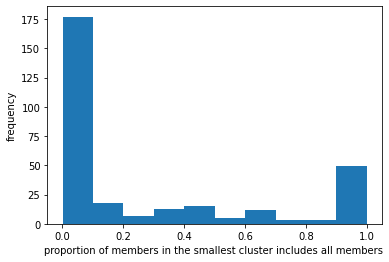

In [ ]:
# stats_df = get_clustering_stats(Z=Z, ctype_to_id=ctype_to_leaf, ind_to_id=ind_to_id)
sns.histplot(x=stats_df['mpd'])
plt.xlabel('Mean pairwise tree dist per group')
plt.ylabel('frequency')
plt.show()

sns.histplot(x=stats_df['lps'])
plt.xlabel('Largest pure cluster')
plt.ylabel('frequency')
plt.show()

plt.hist(x=stats_df['pam'])
plt.xlabel('proportion of members in the smallest cluster includes all members ')
plt.ylabel('frequency')
plt.show()

In [ ]:
stats_df['lps_frac'] =  (stats_df['len'] * stats_df['lps']).astype(int).astype(str)+ '/' + stats_df['len'].astype(int).astype(str) 

In [ ]:
stats_df[stats_df['lps']==1]

,labels,len,lps,mpd,pam,n_p,m_p,s_p,lps_frac
0,AN13B002,2,1.0,2.000000,1.0,1,2,0,2/2
2,AN23B001,2,1.0,2.000000,1.0,1,2,0,2/2
3,AN23B002,2,1.0,2.000000,1.0,1,2,0,2/2
4,AN23B003,2,1.0,2.000000,1.0,1,2,0,2/2
5,AN23B004,2,1.0,2.000000,1.0,1,2,0,2/2
6,AN23B010,2,1.0,2.000000,1.0,1,2,0,2/2
7,AN23B026,2,1.0,2.000000,1.0,1,2,0,2/2
9,IN13B004,6,1.0,4.133333,1.0,1,6,0,6/6
10,IN13B005,6,1.0,4.133333,1.0,1,6,0,6/6
12,IN13B007,2,1.0,2.000000,1.0,1,2,0,2/2


In [ ]:
# vnc_meta[vnc_meta.hemilineage.isin(heminames)][['type', 'hemilineage']].drop_duplicates()

In [ ]:
stats_df['hemi'] = stats_df.labels.apply(ctype_to_hemi_dict.get)

In [ ]:
lps_frac_freq = pd.DataFrame(stats_df['lps_frac'].value_counts()).reset_index()
lps_frac_freq['denom'] = lps_frac_freq['lps_frac'].apply(lambda x: int(x.split('/')[-1]))
lps_frac_freq['numer'] = lps_frac_freq['lps_frac'].apply(lambda x: int(x.split('/')[0]))

In [ ]:
col_dict = {'True': 'green', 'False':'red'}
lps_frac_freq['col'] = lps_frac_freq.apply(lambda x: col_dict.get(str(x.denom==x.numer)), axis=1)

In [ ]:
lps_frac_freq = lps_frac_freq.sort_values(['denom', 'lps_frac']).reset_index()

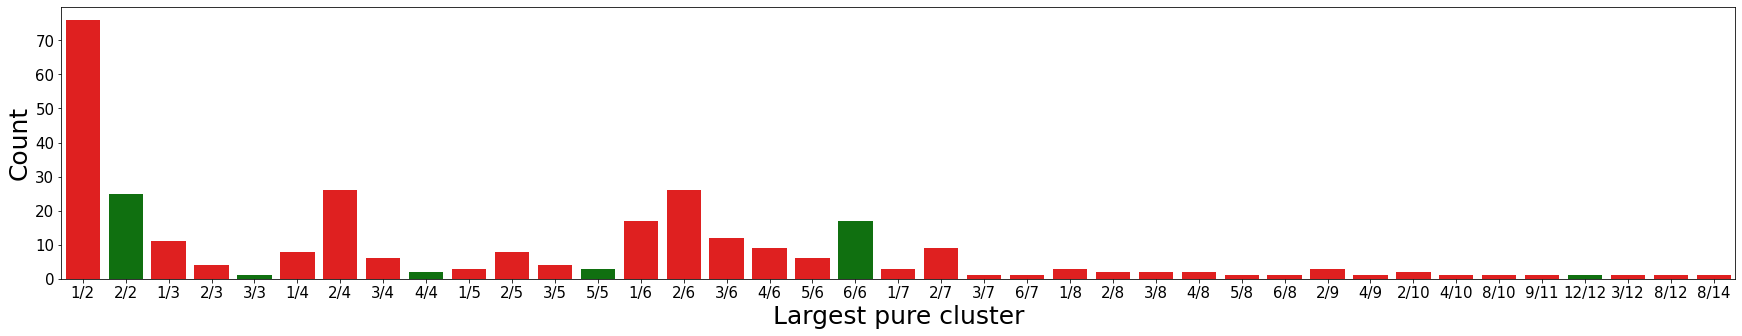

In [ ]:
plt.figure(figsize=(30, 5))

# cols = ['grey' if (x < max(lps_frac_freq.sales)) else 'orange' for x in lps_frac_freq.sales]
ax = sns.barplot(lps_frac_freq, x='lps_frac', y='count', estimator="sum", errorbar=None, palette=lps_frac_freq['col'] )
plt.xlabel('Largest pure cluster', size=25)
plt.ylabel('Count', size=25)
plt.xticks(size=15)
plt.yticks(size=15)
# save=False
# if save:
#     plt.savefig(f'./figs/2024/cccat_v_lpc_hist.png', bbox_inches='tight')
# save=False
# plt.grid()
plt.show()

In [ ]:
stats_df['lps_frac'] = pd.Categorical(stats_df['lps_frac'], lps_frac_freq.lps_frac.values)

In [ ]:
stats_df

,labels,len,lps,mpd,pam,n_p,m_p,s_p,lps_frac,hemi
0,AN13B002,2,1.000000,2.000000,1.000000,1,2,0,2/2,13B
1,AN14A003,6,0.666667,9.466667,0.076923,2,6,0,4/6,14A
2,AN23B001,2,1.000000,2.000000,1.000000,1,2,0,2/2,23B
3,AN23B002,2,1.000000,2.000000,1.000000,1,2,0,2/2,23B
4,AN23B003,2,1.000000,2.000000,1.000000,1,2,0,2/2,23B
...,...,...,...,...,...,...,...,...,...,...
297,IN23B092,2,0.500000,19.000000,0.014815,0,0,2,1/2,23B
298,IN23B093,2,1.000000,2.000000,1.000000,1,2,0,2/2,23B
299,IN23B094,2,0.500000,12.000000,0.017094,0,0,2,1/2,23B
300,MNad07,4,0.500000,6.166667,0.117647,1,2,2,2/4,13B


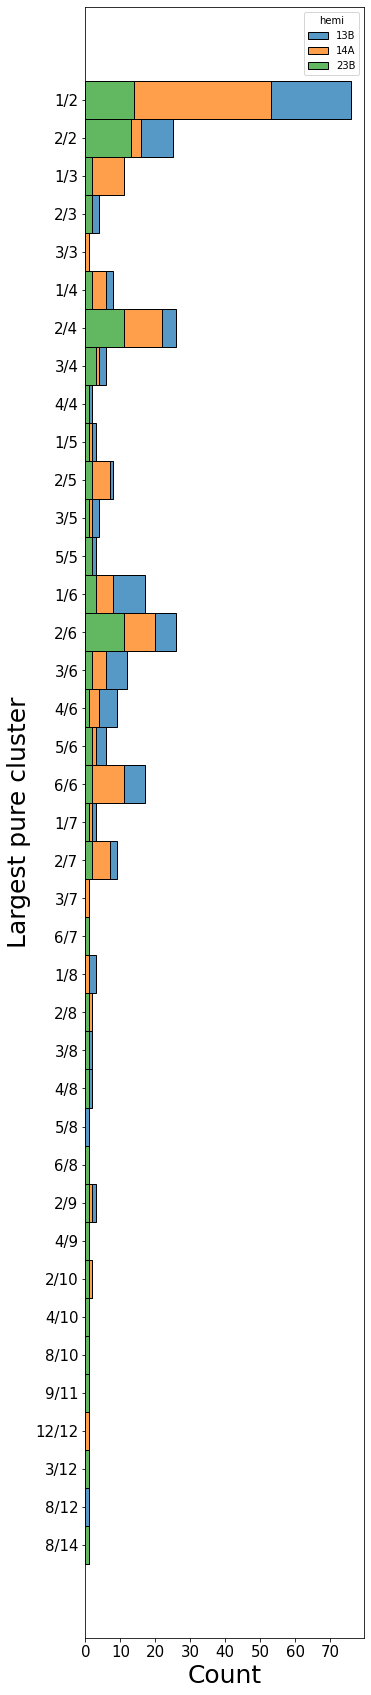

In [ ]:
plt.figure(figsize=(5, 30))

# cols = ['grey' if (x < max(lps_frac_freq.sales)) else 'orange' for x in lps_frac_freq.sales]
sns.histplot(stats_df, y='lps_frac', hue='hemi', multiple='stack')
plt.ylabel('Largest pure cluster', size=25)
plt.xlabel('Count', size=25)
plt.xticks(size=15)
plt.yticks(size=15)
# save=False
# if save:
#     plt.savefig(f'./figs/2024/cccat_v_lpc_hist.png', bbox_inches='tight')
# save=False
# plt.grid()
plt.show()

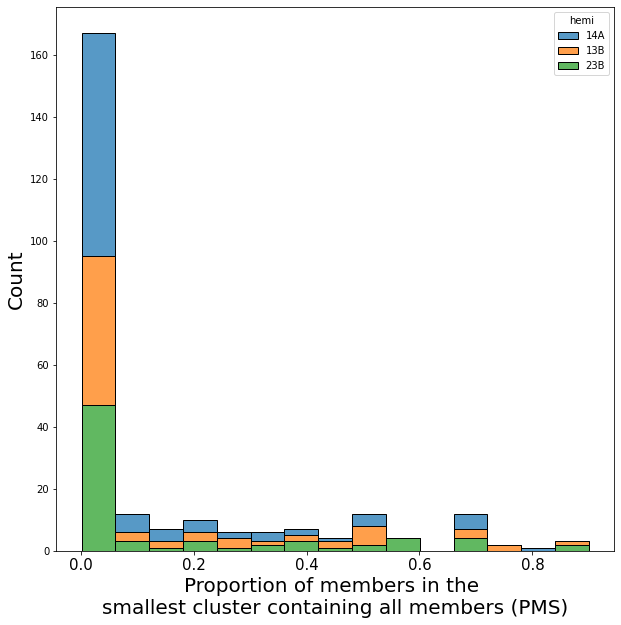

In [ ]:
plt.figure(figsize=(10,10))

sns.histplot(stats_df[stats_df['pam']<1], x='pam', bins=15, hue='hemi',multiple="stack")
plt.ylabel('Count', size=20)
# plt.yticks([0,5,10,15,20], size=15)
plt.xticks(size=15)
# plt.legend(title='Group size', fontsize=10)
plt.xlabel('Proportion of members in the \nsmallest cluster containing all members (PMS)', size=20)

plt.show()

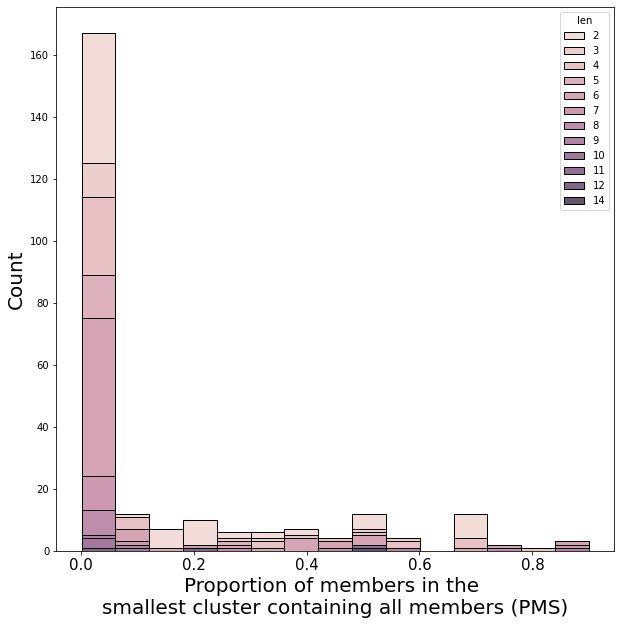

In [ ]:
plt.figure(figsize=(10,10))

sns.histplot(stats_df[stats_df['pam']<1], x='pam', bins=15, hue='len',multiple="stack")
plt.ylabel('Count', size=20)
# plt.yticks([0,5,10,15,20], size=15)
plt.xticks(size=15)
# plt.legend(title='Group size', fontsize=10)
plt.xlabel('Proportion of members in the \nsmallest cluster containing all members (PMS)', size=20)

plt.show()

In [ ]:
M80_pct_df= (stats_df[stats_df['lps']==1])
print('number of cell types perfectly clustered:', len(M80_pct_df))
print('number of neurons in perfect clusters:', M80_pct_df.len.sum())

number of cell types perfectly clustered: 49
number of neurons in perfect clusters: 190


In [ ]:
M80_rct_df = stats_df[(stats_df['lps']<1)&(stats_df['lps']>=0.5)&(stats_df['len']>2)]
print('number of cell types reasonably clustered:', len(M80_rct_df))
print('number of neurons in reasonable clusters 1>LPS>0.5:', M80_rct_df.len.sum())

number of cell types reasonably clustered: 76
number of neurons in reasonable clusters 1>LPS>0.5: 408


In [ ]:
M80_bct_df = stats_df[((stats_df['lps']<.5)&(stats_df['len']>2))|((stats_df['lps']==.5)&(stats_df['len']==2))]
print('number of cell types in bad clusters 0.5>LPS:', len(M80_bct_df))
print('number of neurons in bad clusters 0.5>LPS:', M80_bct_df.len.sum())

number of cell types in bad clusters 0.5>LPS: 177
number of neurons in bad clusters 0.5>LPS: 755


### Clustering stats for hemilineages

In [ ]:
hemi_stat_dict = {}

for label in heminames:
    ids_to_inspect = hemitype_to_leaf[label]
    cl_purity = cluster_purity_test(targets=ids_to_inspect, Z=Z, ind_to_id=ind_to_id)

    largest_pure = max([len(j) for j in cl_purity])#/len(ids_to_inspect)
    # lps.append(largest_pure) 

    n_singletons = sum([len(i)==1 for i in cl_purity])
    n_non_singletons = len(cl_purity) - n_singletons
    n_non_singletons_members = len(ids_to_inspect) - n_singletons
    # print('number of singletons', n_singletons)
    # print('number non-singleton clusters', n_non_singletons)
    # print('number of neurons in non-singleton clusters', n_non_singletons_members)

    hemi_stat_dict[label] = {'n_s':n_singletons, 'm_p':n_non_singletons_members, 'n_p':n_non_singletons, 'lps':largest_pure}

hemi_stat_df = pd.DataFrame.from_dict(hemi_stat_dict, orient='index')

hemi_stat_df['av_size'] = hemi_stat_df['m_p']/hemi_stat_df['n_p']
hemi_stat_df['coverage'] = hemi_stat_df['m_p']/(hemi_stat_df['n_s'] + hemi_stat_df['m_p'])


In [ ]:
M80_hemipurity = hemi_stat_df.sort_values('coverage').sort_values('coverage')

In [ ]:
M80_hemipurity

,n_s,m_p,n_p,lps,av_size,coverage
13B,46,384,65,27,5.907692,0.893023
14A,47,453,91,25,4.978022,0.906000
23B,25,414,61,29,6.786885,0.943052


In [ ]:
hemi_stat_df.m_p.sum() /(hemi_stat_df.m_p.sum() + hemi_stat_df.n_s.sum() )

0.9138056975894814

## M=100

In [ ]:
M=100
dist_df = msize_dist_df[M]

dist_type = 'euclidean_distance'

method='ward'

cond_dist = (dist_df[dist_type].values)
Z = linkage(cond_dist, method=method) ####### linkage
ind_to_id = [str(i) for i in n_ids]


In [ ]:
ctype_to_leaf = vnc_meta[vnc_meta['bodyId'].isin(ind_to_id)].groupby('type').bodyId.apply(list).to_dict()

In [ ]:
hemitype_to_leaf = vnc_meta[vnc_meta['bodyId'].isin(ind_to_id)].groupby('hemilineage').bodyId.apply(list).to_dict()

In [ ]:
# h_clustering_stats = get_clustering_stats(Z=Z, ctype_to_id=hemitype_to_leaf, ind_to_id=ind_to_id)

In [ ]:
label = list(hemitype_to_leaf.keys())[0]
ids_to_inspect = hemitype_to_leaf[label]
cl_purity = cluster_purity_test(targets=ids_to_inspect, Z=Z, ind_to_id=ind_to_id)

largest_pure = max([len(j) for j in cl_purity])/len(ids_to_inspect)
# lps.append(largest_pure) 

n_singletons = sum([len(i)==1 for i in cl_purity])
n_non_singletons = len(cl_purity) - n_singletons
n_non_singletons_members = len(ids_to_inspect) - n_singletons


In [ ]:
n_singletons

30

In [ ]:
n_non_singletons

65

In [ ]:
n_non_singletons_members

400

In [ ]:
cl_object = generate_cluster_evolution(Z=Z, targets=ids_to_inspect, ind_to_id=ind_to_id)
smallest_cl = next(cl_object)


In [ ]:
# h_clustering_stats

In [ ]:
# stats_df = get_clustering_stats(Z=Z, ctype_to_id=ctype_to_leaf, ind_to_id=ind_to_id)
fname = f'./data/vnc/{datadate}_data/gmatching/cluster_analysis/M{M}_hemisample_extrametrics.parquet' # _hemisample_2 is the version without the number of pure clusters etc. 
# stats_df.to_parquet(fname)


In [ ]:
stats_df = pd.read_parquet(fname)

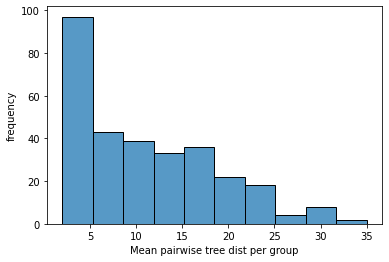

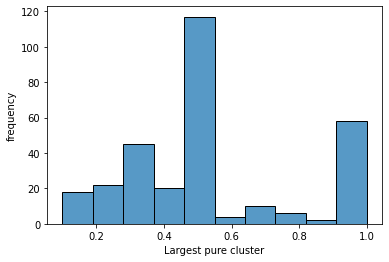

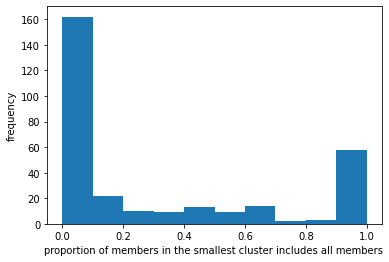

In [ ]:
# stats_df = get_clustering_stats(Z=Z, ctype_to_id=ctype_to_leaf, ind_to_id=ind_to_id)
sns.histplot(x=stats_df['mpd'])
plt.xlabel('Mean pairwise tree dist per group')
plt.ylabel('frequency')
plt.show()

sns.histplot(x=stats_df['lps'])
plt.xlabel('Largest pure cluster')
plt.ylabel('frequency')
plt.show()

plt.hist(x=stats_df['pam'])
plt.xlabel('proportion of members in the smallest cluster includes all members ')
plt.ylabel('frequency')
plt.show()

In [ ]:
stats_df['lps_frac'] =  (stats_df['len'] * stats_df['lps']).astype(int).astype(str)+ '/' + stats_df['len'].astype(int).astype(str) 

In [ ]:
stats_df.head(10)

,labels,len,lps,mpd,pam,n_p,m_p,s_p,lps_frac
0,AN13B002,2,1.000000,2.000000,1.000000,1,2,0,2/2
1,AN14A003,6,0.666667,7.333333,0.098361,2,6,0,4/6
2,AN23B001,2,1.000000,2.000000,1.000000,1,2,0,2/2
3,AN23B002,2,1.000000,2.000000,1.000000,1,2,0,2/2
4,AN23B003,2,1.000000,2.000000,1.000000,1,2,0,2/2
5,AN23B004,2,1.000000,2.000000,1.000000,1,2,0,2/2
6,AN23B010,2,1.000000,2.000000,1.000000,1,2,0,2/2
7,AN23B026,2,1.000000,2.000000,1.000000,1,2,0,2/2
8,IN13B001,6,0.666667,4.666667,0.500000,2,6,0,4/6
9,IN13B004,6,1.000000,4.133333,1.000000,1,6,0,6/6


In [ ]:
stats_df['hemi'] = stats_df.labels.apply(ctype_to_hemi_dict.get)

In [ ]:

M100_pct_df= (stats_df[stats_df['lps']==1])
print('number of cell types perfectly clustered:', len(M100_pct_df))
print('number of neurons in perfect clusters:', M100_pct_df.len.sum())

number of cell types perfectly clustered: 58
number of neurons in perfect clusters: 231


In [ ]:
M100_rct_df = stats_df[(stats_df['lps']<1)&(stats_df['lps']>=0.5)&(stats_df['len']>2)]
print('number of cell types reasonably clustered:', len(M100_rct_df))
print('number of neurons in reasonable clusters 1>LPS>0.5:', M100_rct_df.len.sum())

number of cell types reasonably clustered: 66
number of neurons in reasonable clusters 1>LPS>0.5: 349


In [ ]:
M100_bct_df = stats_df[((stats_df['lps']<.5)&(stats_df['len']>2))|((stats_df['lps']==.5)&(stats_df['len']==2))]
print('number of cell types in bad clusters 0.5>LPS:', len(M100_bct_df))
print('number of neurons in bad clusters 0.5>LPS:', M100_bct_df.len.sum())

number of cell types in bad clusters 0.5>LPS: 178
number of neurons in bad clusters 0.5>LPS: 773


In [ ]:
stats_df

,labels,len,lps,mpd,pam,n_p,m_p,s_p,lps_frac,hemi
0,AN13B002,2,1.000000,2.000000,1.000000,1,2,0,2/2,13B
1,AN14A003,6,0.666667,7.333333,0.098361,2,6,0,4/6,14A
2,AN23B001,2,1.000000,2.000000,1.000000,1,2,0,2/2,23B
3,AN23B002,2,1.000000,2.000000,1.000000,1,2,0,2/2,23B
4,AN23B003,2,1.000000,2.000000,1.000000,1,2,0,2/2,23B
...,...,...,...,...,...,...,...,...,...,...
297,IN23B092,2,0.500000,23.000000,0.006557,0,0,2,1/2,23B
298,IN23B093,2,1.000000,2.000000,1.000000,1,2,0,2/2,23B
299,IN23B094,2,0.500000,16.000000,0.006557,0,0,2,1/2,23B
300,MNad07,4,0.750000,10.666667,0.015748,1,3,1,3/4,13B


In [ ]:
stats_df

,labels,len,lps,mpd,pam,n_p,m_p,s_p,lps_frac,hemi
0,AN13B002,2,1.000000,2.000000,1.000000,1,2,0,2/2,13B
1,AN14A003,6,0.666667,7.333333,0.098361,2,6,0,4/6,14A
2,AN23B001,2,1.000000,2.000000,1.000000,1,2,0,2/2,23B
3,AN23B002,2,1.000000,2.000000,1.000000,1,2,0,2/2,23B
4,AN23B003,2,1.000000,2.000000,1.000000,1,2,0,2/2,23B
...,...,...,...,...,...,...,...,...,...,...
297,IN23B092,2,0.500000,23.000000,0.006557,0,0,2,1/2,23B
298,IN23B093,2,1.000000,2.000000,1.000000,1,2,0,2/2,23B
299,IN23B094,2,0.500000,16.000000,0.006557,0,0,2,1/2,23B
300,MNad07,4,0.750000,10.666667,0.015748,1,3,1,3/4,13B


In [ ]:
lps_frac_freq = pd.DataFrame(stats_df['lps_frac'].value_counts()).reset_index()
lps_frac_freq['denom'] = lps_frac_freq['lps_frac'].apply(lambda x: int(x.split('/')[-1]))
lps_frac_freq['numer'] = lps_frac_freq['lps_frac'].apply(lambda x: int(x.split('/')[0]))

In [ ]:
col_dict = {'True': 'green', 'False':'red'}
lps_frac_freq['col'] = lps_frac_freq.apply(lambda x: col_dict.get(str(x.denom==x.numer)), axis=1)

In [ ]:
lps_frac_freq = lps_frac_freq.sort_values(['denom', 'lps_frac']).reset_index()

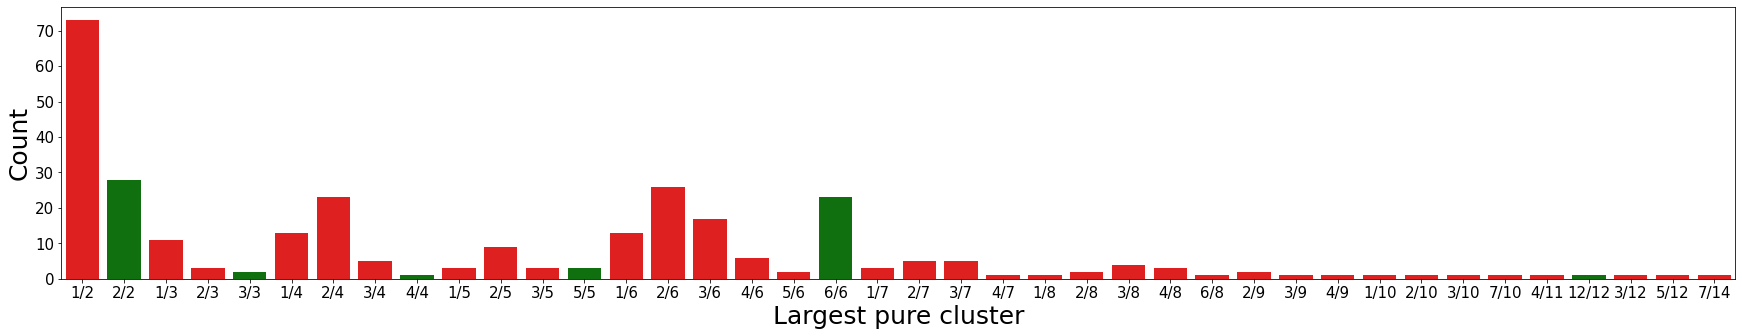

In [ ]:
plt.figure(figsize=(30, 5))

# cols = ['grey' if (x < max(lps_frac_freq.sales)) else 'orange' for x in lps_frac_freq.sales]
ax = sns.barplot(lps_frac_freq, x='lps_frac', y='count', estimator="sum", errorbar=None, palette=lps_frac_freq['col'] )
plt.xlabel('Largest pure cluster', size=25)
plt.ylabel('Count', size=25)
plt.xticks(size=15)
plt.yticks(size=15)
# save=False
# if save:
#     plt.savefig(f'./figs/2024/cccat_v_lpc_hist.png', bbox_inches='tight')
# save=False
# plt.grid()
plt.show()

In [ ]:
stats_df['lps_frac'] = pd.Categorical(stats_df['lps_frac'], lps_frac_freq.lps_frac.values)

In [ ]:
stats_df

,labels,len,lps,mpd,pam,n_p,m_p,s_p,lps_frac,hemi
0,AN13B002,2,1.000000,2.000000,1.000000,1,2,0,2/2,13B
1,AN14A003,6,0.666667,7.333333,0.098361,2,6,0,4/6,14A
2,AN23B001,2,1.000000,2.000000,1.000000,1,2,0,2/2,23B
3,AN23B002,2,1.000000,2.000000,1.000000,1,2,0,2/2,23B
4,AN23B003,2,1.000000,2.000000,1.000000,1,2,0,2/2,23B
...,...,...,...,...,...,...,...,...,...,...
297,IN23B092,2,0.500000,23.000000,0.006557,0,0,2,1/2,23B
298,IN23B093,2,1.000000,2.000000,1.000000,1,2,0,2/2,23B
299,IN23B094,2,0.500000,16.000000,0.006557,0,0,2,1/2,23B
300,MNad07,4,0.750000,10.666667,0.015748,1,3,1,3/4,13B


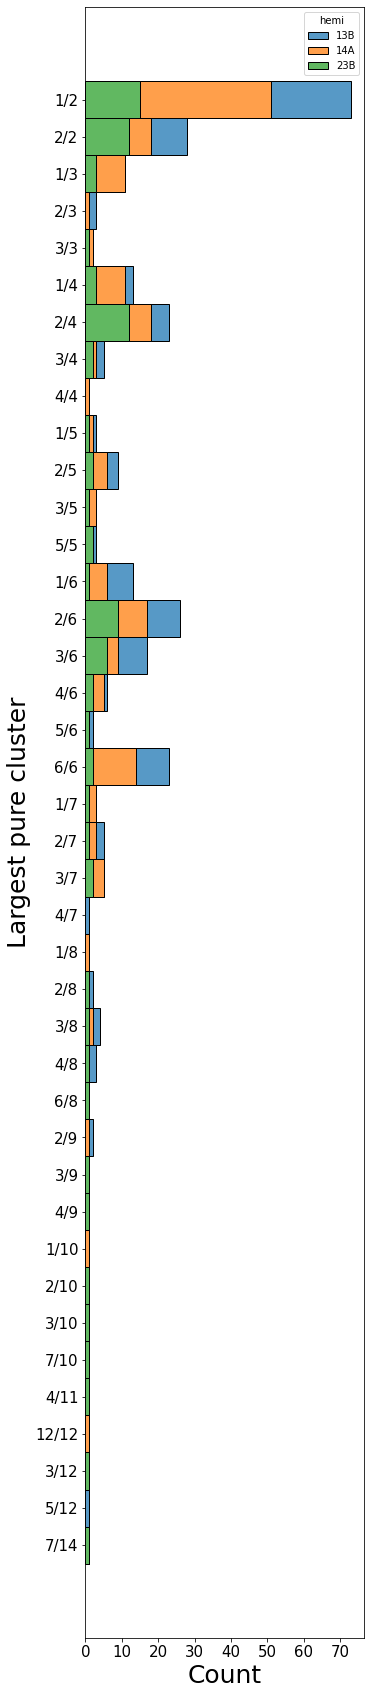

In [ ]:
plt.figure(figsize=(5, 30))

# cols = ['grey' if (x < max(lps_frac_freq.sales)) else 'orange' for x in lps_frac_freq.sales]
sns.histplot(stats_df, y='lps_frac', hue='hemi', multiple='stack')
plt.ylabel('Largest pure cluster', size=25)
plt.xlabel('Count', size=25)
plt.xticks(size=15)
plt.yticks(size=15)
# save=False
# if save:
#     plt.savefig(f'./figs/2024/cccat_v_lpc_hist.png', bbox_inches='tight')
# save=False
# plt.grid()
plt.show()

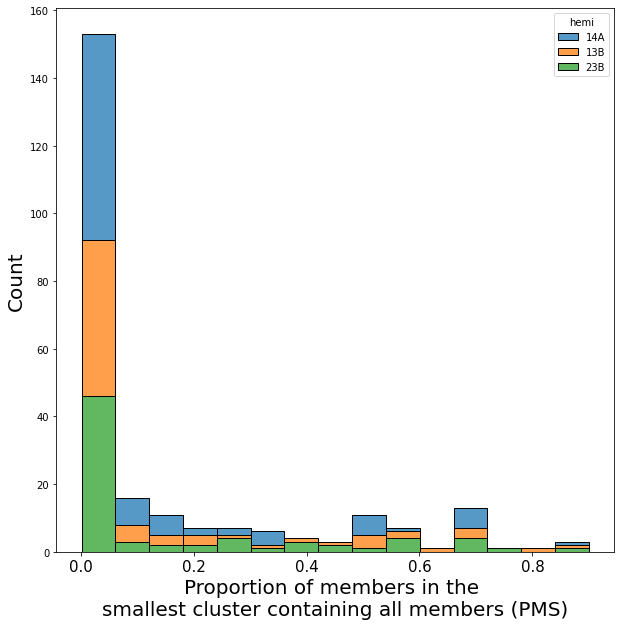

In [ ]:
plt.figure(figsize=(10,10))

sns.histplot(stats_df[stats_df['pam']<1], x='pam', bins=15, hue='hemi',multiple="stack")
plt.ylabel('Count', size=20)
# plt.yticks([0,5,10,15,20], size=15)
plt.xticks(size=15)
# plt.legend(title='Group size', fontsize=10)
plt.xlabel('Proportion of members in the \nsmallest cluster containing all members (PMS)', size=20)

plt.show()

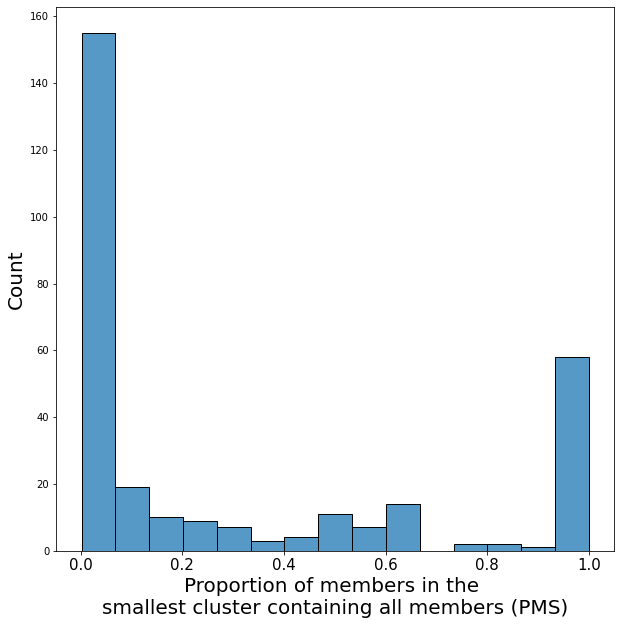

In [ ]:
plt.figure(figsize=(10,10))
# sns.histplot(stats_df, x='pam', bins=15, hue='len',multiple="stack")
sns.histplot(stats_df, x='pam', bins=15)

# sns.histplot(stats_df[stats_df['pam']<1], x='pam', bins=15, hue='len',multiple="stack")
plt.ylabel('Count', size=20)
# plt.yticks([0,5,10,15,20], size=15)
plt.xticks(size=15)
# plt.legend(title='Group size', fontsize=10)
plt.xlabel('Proportion of members in the \nsmallest cluster containing all members (PMS)', size=20)

plt.show()

### clustering stats for hemilienages

In [ ]:
hemi_stat_dict = {}

for label in heminames:
    ids_to_inspect = hemitype_to_leaf[label]
    cl_purity = cluster_purity_test(targets=ids_to_inspect, Z=Z, ind_to_id=ind_to_id)

    largest_pure = max([len(j) for j in cl_purity])#/len(ids_to_inspect)
    # lps.append(largest_pure) 

    n_singletons = sum([len(i)==1 for i in cl_purity])
    n_non_singletons = len(cl_purity) - n_singletons
    n_non_singletons_members = len(ids_to_inspect) - n_singletons
    # print('number of singletons', n_singletons)
    # print('number non-singleton clusters', n_non_singletons)
    # print('number of neurons in non-singleton clusters', n_non_singletons_members)

    hemi_stat_dict[label] = {'n_s':n_singletons, 'm_p':n_non_singletons_members, 'n_p':n_non_singletons, 'lps':largest_pure}

hemi_stat_df = pd.DataFrame.from_dict(hemi_stat_dict, orient='index')

hemi_stat_df['av_size'] = hemi_stat_df['m_p']/hemi_stat_df['n_p']
hemi_stat_df['coverage'] = hemi_stat_df['m_p']/(hemi_stat_df['n_s'] + hemi_stat_df['m_p'])


In [ ]:
M100_hemipurity = hemi_stat_df.sort_values('coverage').sort_values('coverage')

In [ ]:
M100_hemipurity

,n_s,m_p,n_p,lps,av_size,coverage
13B,30,400,65,35,6.153846,0.930233
14A,31,469,81,20,5.790123,0.938000
23B,19,420,48,41,8.750000,0.956720


In [ ]:
hemi_stat_df.m_p.sum() /(hemi_stat_df.m_p.sum() + hemi_stat_df.n_s.sum() )

0.9415631848064281

# joint stats:

In [ ]:
M15_pct_df.loc[:,'M'] = 15

M80_pct_df.loc[:,'M'] = 80
M30_pct_df.loc[:,'M'] = 30
M50_pct_df.loc[:,'M'] = 50
M100_pct_df.loc[:,'M'] = 100

pct_df = pd.concat([M15_pct_df, M50_pct_df, M30_pct_df, M80_pct_df, M100_pct_df], ignore_index=True)

pct_df['Q'] = 'perfect'

In [ ]:
M15_rct_df.loc[:,'M'] = 15
M80_rct_df.loc[:,'M'] = 80

M30_rct_df.loc[:,'M'] = 30
M50_rct_df.loc[:,'M'] = 50
M100_rct_df.loc[:,'M'] = 100

rct_df = pd.concat([M50_rct_df, M30_rct_df, M80_rct_df, M100_rct_df, M15_rct_df], ignore_index=True)

rct_df['Q'] = 'reasonable'

In [ ]:
M100_bct_df

,labels,len,lps,mpd,pam,n_p,m_p,s_p,lps_frac,hemi
11,IN13B006,6,0.333333,13.800000,0.006036,1,2,4,2/6,13B
20,IN13B015,2,0.500000,24.000000,0.002220,0,0,2,1/2,13B
21,IN13B017,6,0.333333,23.066667,0.004383,1,2,4,2/6,13B
27,IN13B023,6,0.166667,8.200000,0.146341,0,0,6,1/6,13B
28,IN13B024,2,0.500000,4.000000,0.500000,0,0,2,1/2,13B
...,...,...,...,...,...,...,...,...,...,...
293,IN23B088,3,0.333333,16.000000,0.003330,0,0,3,1/3,23B
294,IN23B089,6,0.333333,15.133333,0.012048,1,2,4,2/6,23B
295,IN23B090,5,0.400000,23.800000,0.010040,1,2,3,2/5,23B
297,IN23B092,2,0.500000,23.000000,0.006557,0,0,2,1/2,23B


In [ ]:
M15_bct_df.loc[:,'M'] = 15
M80_bct_df.loc[:,'M'] = 80

M30_bct_df.loc[:,'M'] = 30
M50_bct_df.loc[:,'M'] = 50
M100_bct_df.loc[:,'M'] = 100

bct_df = pd.concat([M80_bct_df, M30_bct_df, M50_bct_df, M100_bct_df, M15_bct_df], ignore_index=True)
bct_df['Q'] = 'bad'

In [ ]:
all_q_df = pd.concat([pct_df,rct_df, bct_df], ignore_index=True)

In [ ]:
all_q_df[all_q_df['M']==100].sort_values('hemi')

,labels,len,lps,mpd,pam,n_p,m_p,s_p,lps_frac,hemi,M,Q
192,AN13B002,2,1.000000,2.000000,1.000000,1,2,0,2/2,13B,100,perfect
1143,IN13B045,6,0.333333,21.133333,0.004383,1,2,4,2/6,13B,100,bad
1142,IN13B044,9,0.222222,12.888889,0.009989,3,6,3,2/9,13B,100,bad
1141,IN13B043,2,0.500000,3.000000,0.666667,0,0,2,1/2,13B,100,bad
1140,IN13B041,2,0.500000,5.000000,0.200000,0,0,2,1/2,13B,100,bad
...,...,...,...,...,...,...,...,...,...,...,...,...
501,IN23B040,6,0.500000,13.266667,0.006659,1,3,3,3/6,23B,100,reasonable
502,IN23B043,10,0.700000,10.688889,0.020080,2,10,0,7/10,23B,100,reasonable
503,IN23B044,4,0.500000,7.333333,0.129032,1,2,2,2/4,23B,100,reasonable
494,IN23B021,4,0.500000,6.166667,0.285714,1,2,2,2/4,23B,100,reasonable


In [ ]:
Ms = [15, 30,50,80,100]
ct_cov_vals = []
for i in Ms:
    ct_cov_val = all_q_df[all_q_df['M']==i].m_p.sum()/all_q_df[all_q_df['M']==i].len.sum()
    ct_cov_vals.append(ct_cov_val)



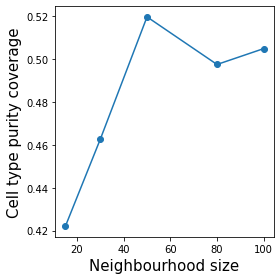

In [ ]:
plt.figure(figsize=(4,4))
plt.plot(Ms, ct_cov_vals, 'o-')
plt.xlabel('Neighbourhood size', size=15)
plt.ylabel('Cell type purity coverage', size=15)
plt.tight_layout()

In [ ]:
M15_hemipurity

,n_s,m_p,n_p,av_size,coverage
13B,84,346,75,4.613333,0.804651
14A,88,412,110,3.745455,0.824000
23B,74,365,76,4.802632,0.831435


In [ ]:
M_purity = [M15_hemipurity, M30_hemipurity, M50_hemipurity, M80_hemipurity,  M100_hemipurity]

M_hemicoverage = []
for tab in M_purity: 
    coverage = tab.m_p.sum() /(tab.m_p.sum() + tab.n_s.sum() )
    M_hemicoverage.append(coverage)

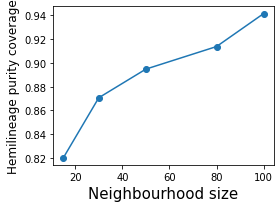

In [ ]:
plt.figure(figsize=(4,3))
plt.plot(Ms, M_hemicoverage, 'o-')
plt.xlabel('Neighbourhood size', size=15)
plt.ylabel('Hemilineage purity coverage', size=12)
plt.tight_layout()

In [ ]:

M_hemi_avg= []
for tab in M_purity: 
    coverage = tab.m_p.sum()/tab.n_p.sum()
    M_hemi_avg.append(coverage)

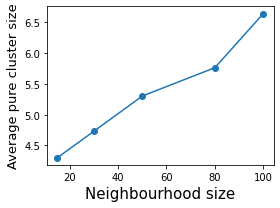

In [ ]:
plt.figure(figsize=(4,3))
plt.plot(Ms, M_hemi_avg, 'o-')
plt.xlabel('Neighbourhood size', size=15)
plt.ylabel('Average pure cluster size', size=13)
plt.tight_layout()

In [ ]:
M_hemi_lps = []
for tab in M_purity: 
    coverage = tab.lps.max()
    M_hemi_lps.append(coverage)

In [ ]:
tab.loc[hemiexample].lps

20.0

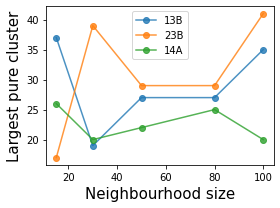

In [ ]:
plt.figure(figsize=(4,3))
# plt.plot(Ms, ct_cov_vals, 'o-', label='altogether')
for index, hemiexample in enumerate(heminames):
    hemi_lps = []
    for tab in M_purity: 
        coverage = tab.loc[hemiexample].lps
        hemi_lps.append(coverage)
    plt.plot(Ms, hemi_lps, 'o-', alpha=0.8, label=hemiexample)
plt.legend()
plt.xlabel('Neighbourhood size', size=15)
plt.ylabel('Largest pure cluster', size=15)
plt.tight_layout()

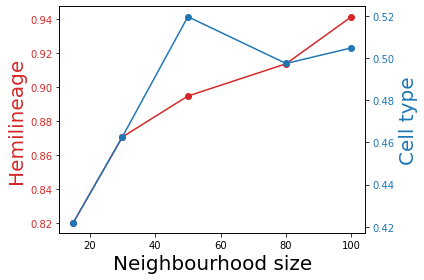

In [ ]:
fig, ax1 = plt.subplots(figsize=(6,4))

color = 'tab:red'
ax1.set_xlabel('Neighbourhood size', size=20)

# ax1.set_ylabel('# of new matching', color=color)
# ax1.plot(new_ntype_matching_n[:,0], new_ntype_matching_n[:, 1], color=color, marker='o')
ax1.set_ylabel('Hemilineage', color=color, size=20)
ax1.plot(Ms, M_hemicoverage, color=color, marker='o')

ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis




color = 'tab:blue'
# ax2.set_ylabel('# cell type matching', color=color)  
# ax2.plot(deltas, n_typematches, color=color, marker='')
ax2.set_ylabel('Cell type', color=color, size=20)
ax2.plot(Ms, ct_cov_vals, color=color, marker='o',)

ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [ ]:
# tips = sns.load_dataset("tips")

# # Create a categorical plot
# g = sns.catplot(data=tips, x="day", y="total_bill", col="time", kind="bar", height=4, aspect=0.7)

# # Customize the plot
# g.set_axis_labels("Day of the Week", "Total Bill")
# g.set_titles("{col_name}")
# g.add_legend()

# # Show the plot
# plt.show()

In [ ]:
all_q_df

,labels,len,lps,mpd,pam,n_p,m_p,s_p,lps_frac,hemi,M,Q
0,AN14A003,6,1.000000,4.133333,1.000000,1,6,0,6/6,14A,15,perfect
1,AN23B003,2,1.000000,2.000000,1.000000,1,2,0,2/2,23B,15,perfect
2,AN23B026,2,1.000000,2.000000,1.000000,1,2,0,2/2,23B,15,perfect
3,IN13B001,6,1.000000,4.133333,1.000000,1,6,0,6/6,13B,15,perfect
4,IN13B005,6,1.000000,4.133333,1.000000,1,6,0,6/6,13B,15,perfect
...,...,...,...,...,...,...,...,...,...,...,...,...
1505,IN23B088,3,0.333333,26.000000,0.002191,0,0,3,1/3,23B,15,bad
1506,IN23B089,6,0.333333,10.066667,0.030000,1,2,4,2/6,23B,15,bad
1507,IN23B090,5,0.200000,22.800000,0.003652,0,0,5,1/5,23B,15,bad
1508,IN23B091,4,0.250000,14.833333,0.008772,0,0,4,1/4,23B,15,bad


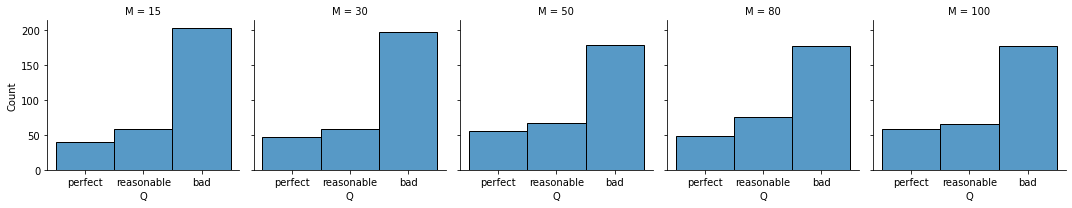

In [ ]:
g = sns.FacetGrid(all_q_df, col="M")
g.map_dataframe(sns.histplot, x="Q")

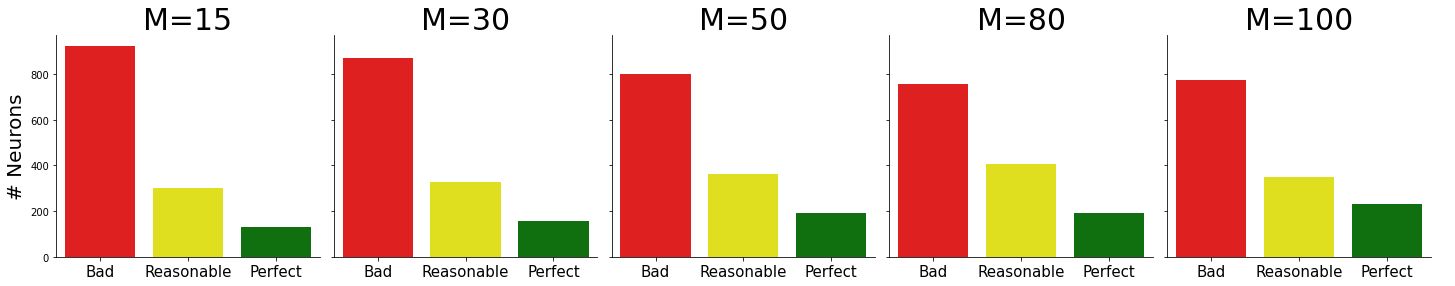

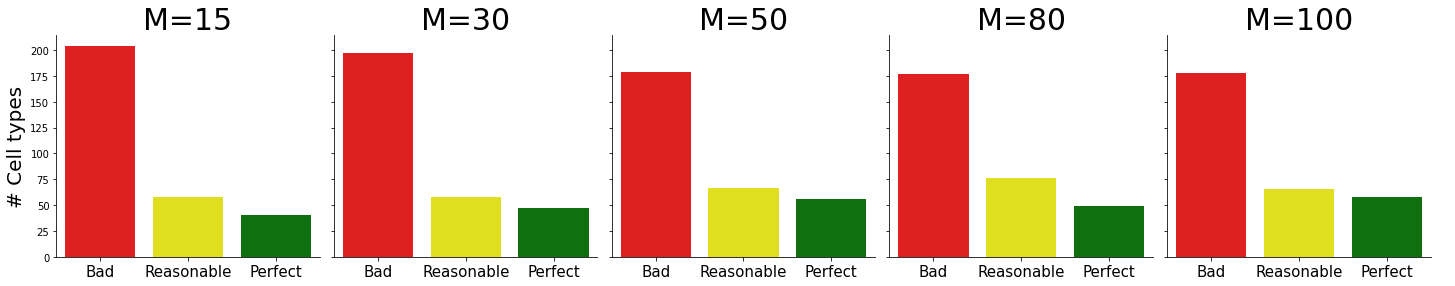

In [ ]:
cat_to_plot = all_q_df.groupby(['M', 'Q'],as_index=False).agg({'len':'sum', 'labels':'count'})
qorder = ['bad', 'reasonable', 'perfect']
cols = ['red', 'yellow', 'green']
g = sns.catplot(data=cat_to_plot, x="Q", y="len", col="M", kind="bar",order=qorder, height=4, aspect=1, palette=cols)
# Customize the plot
g.set_axis_labels("", "# Neurons", fontsize=20)
g.set_titles("M={col_name}", size=30)
# g.set_yticklabels(size=15)
g.set_xticklabels(['Bad', 'Reasonable', 'Perfect'], size=15)

g.add_legend()

# plt.savefig(f'./figures/VNC/{datadate}/nnuerons_quality.png', bbox_inches='tight', dpi=300)
# Show the plot
plt.show()

g = sns.catplot(data=cat_to_plot, x="Q", y="labels", col="M", kind="bar", order=qorder, height=4, aspect=1, palette=cols)
# Customize the plot
g.set_axis_labels("", "# Cell types", fontsize=20)
g.set_titles("M={col_name}", size=30)
g.set_xticklabels(['Bad', 'Reasonable', 'Perfect'], size=15)

g.add_legend()
# plt.savefig(f'./figures/VNC/{datadate}/nctypes_quality.png', bbox_inches='tight', dpi=300)

# Show the plot
plt.show()

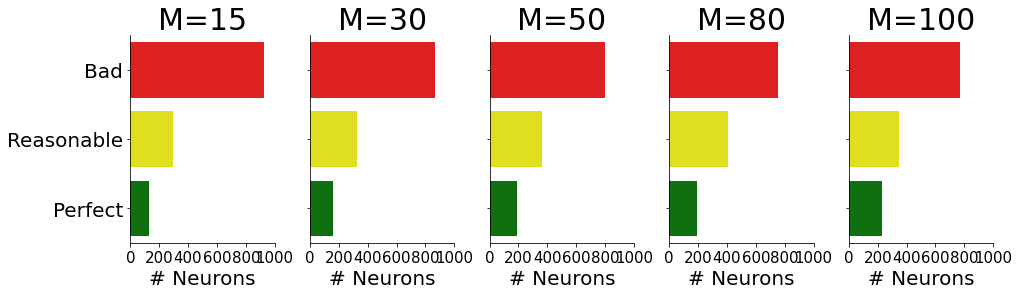

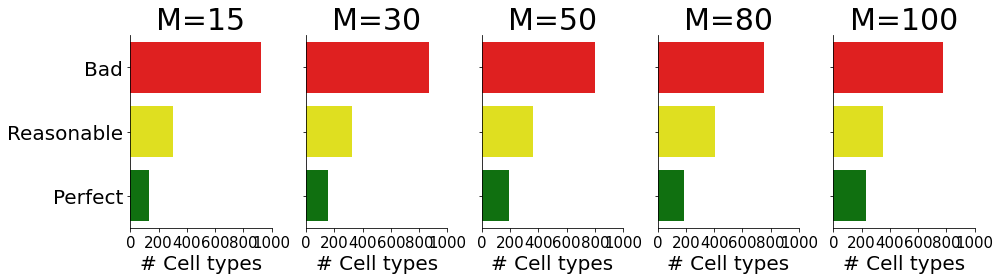

In [ ]:
cat_to_plot = all_q_df.groupby(['M', 'Q'],as_index=False).agg({'len':'sum', 'labels':'count'})
qorder = ['bad', 'reasonable', 'perfect']
cols = ['red', 'yellow', 'green']
g = sns.catplot(data=cat_to_plot, y="Q", x="len", col="M", kind="bar",order=qorder, height=4, aspect=0.7, palette=cols)
# Customize the plot
g.set_axis_labels("# Neurons", "", fontsize=20)
g.set_xticklabels(size=15)
g.set_yticklabels(['Bad', 'Reasonable', 'Perfect'], size=20)
plt.tight_layout()
g.set_titles("M={col_name}", size=30)
g.add_legend()

# plt.savefig(f'./figures/VNC/{datadate}/nnuerons_quality.png', bbox_inches='tight', dpi=300)
# Show the plot
plt.show()


g = sns.catplot(data=cat_to_plot, y="Q", x="len", col="M", kind="bar", order=qorder, height=4, aspect=0.7, palette=cols)
# Customize the plot
g.set_axis_labels("# Cell types", "", fontsize=20)
g.set_titles("M={col_name}", size=30)
g.set_xticklabels(size=15)
g.set_yticklabels(['Bad', 'Reasonable', 'Perfect'], size=20)
plt.tight_layout()


# g = sns.catplot(data=cat_to_plot, x="Q", y="labels", col="M", kind="bar", order=qorder, height=4, aspect=0.7, palette=cols)
# # Customize the plot
# g.set_axis_labels("", "# Cell types", fontsize=20)
# g.set_titles("M={col_name}", size=30)


# plt.savefig(f'./figures/VNC/{datadate}/nctypes_quality.png', bbox_inches='tight', dpi=300)

# Show the plot
plt.show()

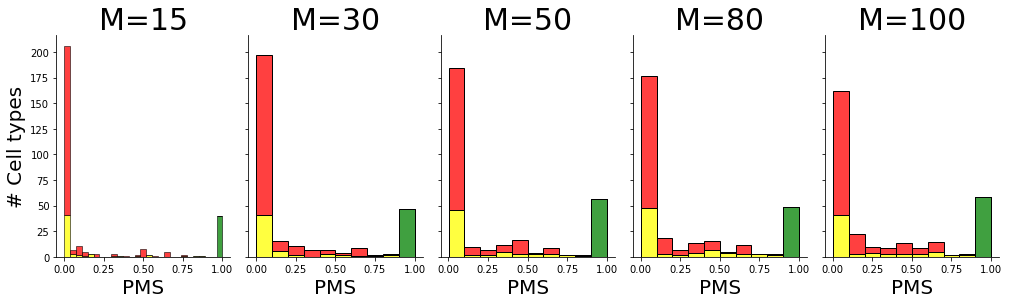

In [ ]:
g = sns.FacetGrid(all_q_df, col="M", height=4, aspect=0.7)
g.map_dataframe(sns.histplot, x="pam", hue='Q', multiple='stack', palette=cols, hue_order=qorder, )
g.set_xlabels('PMS', size=20)
g.set_ylabels('# Cell types', size=20)

g.set_titles("M={col_name}", size=30)

# plt.savefig(f'./figures/VNC/{datadate}/nctypes_pms.png', bbox_inches='tight', dpi=300)

plt.show()

In [ ]:
perfect_size2_Ms = all_q_df.query("(Q=='perfect')&(len==2)").groupby('labels').M.apply(list).sort_values()

perfect_size2_Ms[perfect_size2_Ms.apply(len)==3].index.to_numpy()

array(['IN23B034', 'IN14A066', 'IN13B015', 'IN23B093', 'IN13B068',
       'IN13B053', 'IN13B007', 'IN13B020'], dtype=object)

In [ ]:
bad_size2_noMs = all_q_df.query("(pam<0.5)&(len==2)").groupby('labels').M.apply(list).sort_values()

bad_size2_noMs[bad_size2_noMs.apply(len)==3].index.to_numpy()

array(['IN13B043', 'AN23B002', 'IN14A041', 'IN14A079', 'IN13B081',
       'IN23B051', 'IN14A112', 'IN14A065', 'IN23B061', 'IN14A088',
       'IN14A063', 'IN23B042', 'IN23B073'], dtype=object)

In [ ]:
perfect_size2_Ms.apply(str).unique()

array(['[15]', '[15, 30]', '[15, 50, 30]', '[15, 50, 30, 80]',
       '[15, 50, 30, 80, 100]', '[15, 50, 30, 100]', '[15, 50, 80]',
       '[15, 50, 80, 100]', '[15, 80]', '[15, 80, 100]', '[30]',
       '[30, 100]', '[50]', '[50, 30]', '[50, 30, 80]',
       '[50, 30, 80, 100]', '[50, 30, 100]', '[50, 80]', '[50, 80, 100]',
       '[50, 100]', '[80]', '[80, 100]', '[100]'], dtype=object)

In [ ]:
perfect_size2_Ms[perfect_size2_Ms.apply(len)==2].reset_index()

,labels,M
0,IN23B042,"[15, 30]"
1,IN14A063,"[15, 30]"
2,IN23B092,"[15, 30]"
3,IN14A039,"[15, 30]"
4,IN14A099,"[15, 80]"
5,IN13B069,"[30, 100]"
6,IN23B073,"[50, 30]"
7,IN14A116,"[50, 30]"
8,IN23B050,"[50, 80]"
9,IN13B024,"[50, 80]"


In [ ]:
all_q_df.query("Q=='perfect'").drop_duplicates(subset='labels', keep=False)

,labels,len,lps,mpd,pam,n_p,m_p,s_p,lps_frac,hemi,M,Q
9,IN13B051,2,1.0,2.000000,1.0,1,2,0,2/2,13B,15,perfect
10,IN13B076,6,1.0,4.000000,1.0,1,6,0,6/6,13B,15,perfect
11,IN13B082,2,1.0,2.000000,1.0,1,2,0,2/2,13B,15,perfect
17,IN14A032,2,1.0,2.000000,1.0,1,2,0,2/2,14A,15,perfect
20,IN14A055,2,1.0,2.000000,1.0,1,2,0,2/2,14A,15,perfect
21,IN14A062,2,1.0,2.000000,1.0,1,2,0,2/2,14A,15,perfect
23,IN14A065,2,1.0,2.000000,1.0,1,2,0,2/2,14A,15,perfect
25,IN14A098,2,1.0,2.000000,1.0,1,2,0,2/2,14A,15,perfect
27,IN14A103,2,1.0,2.000000,1.0,1,2,0,2/2,14A,15,perfect
62,IN13B077,2,1.0,2.000000,1.0,1,2,0,2/2,13B,50,perfect


In [ ]:
all_q_df.query("Q=='perfect'").drop_duplicates(subset='labels', keep=False).query('len==2')

,labels,len,lps,mpd,pam,n_p,m_p,s_p,lps_frac,hemi,M,Q
9,IN13B051,2,1.0,2.0,1.0,1,2,0,2/2,13B,15,perfect
11,IN13B082,2,1.0,2.0,1.0,1,2,0,2/2,13B,15,perfect
17,IN14A032,2,1.0,2.0,1.0,1,2,0,2/2,14A,15,perfect
20,IN14A055,2,1.0,2.0,1.0,1,2,0,2/2,14A,15,perfect
21,IN14A062,2,1.0,2.0,1.0,1,2,0,2/2,14A,15,perfect
23,IN14A065,2,1.0,2.0,1.0,1,2,0,2/2,14A,15,perfect
25,IN14A098,2,1.0,2.0,1.0,1,2,0,2/2,14A,15,perfect
27,IN14A103,2,1.0,2.0,1.0,1,2,0,2/2,14A,15,perfect
62,IN13B077,2,1.0,2.0,1.0,1,2,0,2/2,13B,50,perfect
74,IN14A054,2,1.0,2.0,1.0,1,2,0,2/2,14A,50,perfect


In [ ]:
all_q_df.query("Q=='bad'").query('len==2').query('M==80').query('pam<0.5').labels.tolist()

['IN13B039',
 'IN13B041',
 'IN13B048',
 'IN13B049',
 'IN13B051',
 'IN13B053',
 'IN13B059',
 'IN13B062',
 'IN13B066',
 'IN13B067',
 'IN13B069',
 'IN13B072',
 'IN13B075',
 'IN13B077',
 'IN13B084',
 'IN13B085',
 'IN13B094',
 'IN13B099',
 'IN13B102',
 'IN14A016',
 'IN14A030',
 'IN14A031',
 'IN14A032',
 'IN14A035',
 'IN14A046',
 'IN14A053',
 'IN14A054',
 'IN14A057',
 'IN14A060',
 'IN14A062',
 'IN14A063',
 'IN14A065',
 'IN14A066',
 'IN14A069',
 'IN14A072',
 'IN14A073',
 'IN14A075',
 'IN14A080',
 'IN14A083',
 'IN14A084',
 'IN14A088',
 'IN14A089',
 'IN14A091',
 'IN14A092',
 'IN14A097',
 'IN14A098',
 'IN14A101',
 'IN14A102',
 'IN14A104',
 'IN14A116',
 'IN14A123',
 'IN23B034',
 'IN23B042',
 'IN23B048',
 'IN23B053',
 'IN23B061',
 'IN23B069',
 'IN23B073',
 'IN23B076',
 'IN23B082',
 'IN23B083',
 'IN23B092',
 'IN23B094']

In [ ]:
all_q_df.query("Q=='perfect'").drop_duplicates(subset='labels', keep=False).query('(len==2)&(M==30)').labels.tolist()

['IN13B066', 'IN14A069', 'IN14A075', 'IN14A112']

In [ ]:
# all_q_df.groupby(['labels']).get_group('IN12A047')

## Evaluation II

Number of pure clusters

## WIP:

In [ ]:
ggg

NameError: name 'ggg' is not defined

In [ ]:

def pairwise_tree_dists(ids, adjlist, ind_dict):
    '''Pairwise tree distance calculation of all by all in ids list'''

    dist_calculations = []

    for i in range(len(ids)): 
        A_id = ids[i]
        for j in range(i+1, len(ids)):
            B_id = ids[j]
            dist = tree_search(nodes=[A_id], targets=[B_id], adjlist=adjlist, indices=ind_dict)
            dist_calculations.append({'A_id':A_id, 'B_id':B_id, 'tree_dist':dist[0]})

    dist_calculations = pd.DataFrame(dist_calculations)
    return dist_calculations


def cluster_purity_test(targets, Z, ind_to_id):
    '''From a set of nodes in targets, gather information about the sizes of pure clusters within the dendrogram, Z. 
    '''
    visited = set([])

    separated_clusters = []
    for i in targets:
        if i in visited: # if the clusters are already determined, then don't need to do the same calculation twice.
            continue
        
        cl_gen = generate_cluster_evolution(Z=Z, targets=[i], ind_to_id=ind_to_id)

        prev_cluster= [i]
        while True:

            next_cluster=next(cl_gen)
            condition = len(set(next_cluster) - set(targets)) > 0

            if condition: 
                separated_clusters.append(prev_cluster)
                # print(prev_cluster, next_cluster)
                # print(f'{len(prev_cluster)}/{len(targets)}')
                visited |= set(prev_cluster)
                break
            prev_cluster = next_cluster
        if len(prev_cluster) == len(targets):
            # print('All nodes clustered together')
            break
    return separated_clusters

def get_network_from_tree_2(Z):
    '''
    Get the network representation using linkage matrix. 
    The node names will refer to the indices of the (condensed) distance matrix used to calculate Z.  

    params:
    Z : linkage matrix 
    ind_to_id : list of index ids in order of vectors used to create Z
    
    OUTPUT: 
    edge list of the tree network created by the dendrogram. 
    '''

    # Get dendrogramic representation:
    dendrograms = scipy.cluster.hierarchy.dendrogram(Z, labels=None, no_plot=True)
    rootnode, nodelist = cluster.hierarchy.to_tree(Z, rd=True) 
    bools = [i.is_leaf() for i in nodelist]
    opp_bools = list(map(lambda x: not x, bools))
    not_leaves = np.array([i.get_id() for i in nodelist])[opp_bools]


    lst = [i.pre_order(lambda x: x.id) for i in nodelist]
    nodelist=[int(i) for i in dendrograms['ivl']]
    # node_dicts = dict(zip(dendrograms['leaves'], nodelist))
    lst = [[int(j) for j in i] for i in lst]
    list_array = np.array(lst, dtype=object)[not_leaves].tolist()

    next_node_id = len(nodelist)

    edgelist= []
    while len(list_array) != 0:
        for i in list_array:
            if len(i) == 2:
                edgelist.append((i[0], next_node_id))
                edgelist.append((i[1], next_node_id))
                list_array.remove(i)
                for j in list_array:
                    if i[0] in j and i[1] in j:
                        j.remove(i[1])
                        j.remove(i[0])
                        j.append(next_node_id)
                next_node_id += 1

    return edgelist


def get_clustering_stats_2(Z, ctype_to_id, ind_to_id):
    '''Given:
    Z: linkage matrix
    ctype_to_id: node type : list of ids dictionary
    
    return the df containing the:
    largest pure cluster as a fraction of the total number in the cluster
    mean pariwise tree distance
    proportion of all members in the cluster in the smallest cluster that contains all members in the node type. 
    
    NEW: Uses get_network_from_tree_2 which doesn't require ind_to_id... saves edge_list with integer indices
    NEW: saves the number of pure clusters (>1 membership), number of singletons, and the number of members in pure clusters. 
    
    '''
    
    numerical_id_dict = dict(zip( ind_to_id,np.arange(len(ind_to_id)))) # dictionary to idnices to string id. 

    edge_list = get_network_from_tree_2(Z=Z)

    ind_dict, adjlist = get_adj_from_edgelist(edge_list) # getting ind dict is redundant if edge list is with numerical int labels

    labels = list(ctype_to_id.keys())

    lps = [] # largest pure clusters
    mpd = [] # mean pariwise tree distances
    pam = [] # proportion of ids of all members in the smallest cluster. 
    non_single_labels = []
    lens = []
    n_p = []
    m_p = []
    s_p = []

    for i in labels: 
        ids_to_inspect = ctype_to_id[i]
        if len(ids_to_inspect) ==1:
            continue
        non_single_labels.append(i)

        numerical_ids = [numerical_id_dict[ids] for ids in ids_to_inspect] # convert to numerical indices as adjlist is in numerical indices
        tdist_df = pairwise_tree_dists(ids=numerical_ids, adjlist=adjlist, ind_dict=ind_dict)
        mpd.append(tdist_df.tree_dist.mean())

        cl_purity = cluster_purity_test(targets=ids_to_inspect, Z=Z, ind_to_id=ind_to_id)
        largest_pure = max([len(j) for j in cl_purity])/len(ids_to_inspect)
        lps.append(largest_pure) 

        n_singletons = sum([len(i)==1 for i in cl_purity])
        n_non_singletons = len(cl_purity) - n_singletons
        n_non_singletons_members = len(ids_to_inspect) - n_singletons
        # average_members_per_pc = n_non_singletons_members/n_non_singletons
        n_p.append(n_non_singletons)
        m_p.append(n_non_singletons_members)
        s_p.append(n_singletons)

        cl_object = generate_cluster_evolution(Z=Z, targets=ids_to_inspect, ind_to_id=ind_to_id)
        smallest_cl = next(cl_object)
        prop_all_members = len(ids_to_inspect)/len(smallest_cl)
        pam.append(prop_all_members)
        lens.append(len(ids_to_inspect))
    cl_stats_df = pd.DataFrame(data={'labels':non_single_labels, 'len':lens, 'lps':lps, 'mpd':mpd, 'pam':pam, \
                                     'n_p':n_p, 'm_p':m_p, 's_p':s_p})
    

    return cl_stats_df


In [ ]:
def get_network_from_tree(Z, ind_to_id):
    '''
    params:
    Z : linkage matrix 
    ind_to_id : list of index ids in order of vectors used to create Z
    
    OUTPUT: 
    edge list of the tree network created by the dendrogram. 
    '''

    # Get dendrogramic representation:
    dendrograms = cluster.hierarchy.dendrogram(Z, labels=ind_to_id, get_leaves=True, no_plot=True);
    rootnode, nodelist = cluster.hierarchy.to_tree(Z, rd=True) 

    bools = [i.is_leaf() for i in nodelist]
    opp_bools = list(map(lambda x: not x, bools))
    not_leaves = np.array([i.get_id() for i in nodelist])[opp_bools]


    # The network representation:
    lst = [i.pre_order(lambda x: x.id) for i in nodelist]
    nodelist=[str(i) for i in dendrograms['ivl']]
    node_dicts = dict(zip(dendrograms['leaves'], nodelist))
    lst = [[node_dicts[j] for j in i] for i in lst]
    list_array = np.array(lst, dtype=object)[not_leaves].tolist()

    edgelist= []
    while len(list_array) !=0:
        for i in list_array:
            if len(i) == 2:
                edgelist.append((i[0], i[0] + i[1]))
                edgelist.append((i[1], i[0] + i[1]))
                list_array.remove(i)
                for j in list_array:
                    if i[0] in j and i[1] in j:
                        j.remove(i[1])
                        j.remove(i[0])
                        j.append(i[0] + i[1])
    return edgelist


In [ ]:
sample_ids = n_ids[:10]

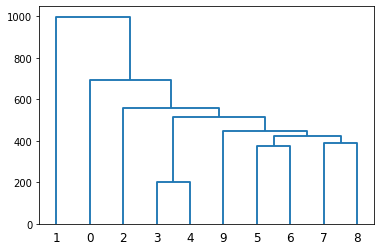

In [ ]:
M=30
dist_df = msize_dist_df[M]
sample_dist_df = dist_df[(dist_df['id_1'].isin(sample_ids))&(dist_df['id_2'].isin(sample_ids))]

dist_type = 'euclidean_distance'

method='ward'
ind_to_id = sample_ids
cond_dist = (sample_dist_df[dist_type].values)
Z = linkage(cond_dist, method=method) ####### linkage
col_dendrogram = scipy.cluster.hierarchy.dendrogram(Z, color_threshold=0, labels=ind_to_id)
dendrograms = scipy.cluster.hierarchy.dendrogram(Z, color_threshold=0, labels=None)

In [ ]:
ind_to_id

['10004',
 '100072',
 '10019',
 '100272',
 '100351',
 '100401',
 '100451',
 '100789',
 '100872',
 '100968']

In [ ]:
cluster_purity_test(targets=sample_ids[5:], Z=Z, ind_to_id=ind_to_id)

[['100968', '100401', '100451', '100789', '100872']]

In [ ]:
ctype_to_id = {'type_1':sample_ids[:4], 'type_2':sample_ids[4:7], 'type_3':sample_ids[7:]}

In [ ]:
ctype_to_id

{'type_1': ['10004', '100072', '10019', '100272'],
 'type_2': ['100351', '100401', '100451'],
 'type_3': ['100789', '100872', '100968']}

In [ ]:
get_clustering_stats_2(Z=Z, ctype_to_id=ctype_to_id, ind_to_id=ind_to_id)

,labels,len,lps,mpd,pam,n_p,m_p,s_p
0,type_1,4,0.250000,4.166667,0.400000,0,0,4
1,type_2,3,0.666667,4.666667,0.428571,1,2,1
2,type_3,3,0.666667,3.333333,0.600000,1,2,1


[[3, 4], [5, 6], [7, 8], [5, 6, 7, 8], [9, 5, 6, 7, 8], [3, 4, 9, 5, 6, 7, 8], [2, 3, 4, 9, 5, 6, 7, 8], [0, 2, 3, 4, 9, 5, 6, 7, 8], [1, 0, 2, 3, 4, 9, 5, 6, 7, 8]]


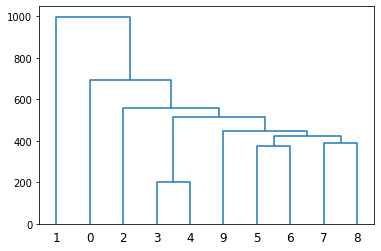

In [ ]:
dendrograms = scipy.cluster.hierarchy.dendrogram(Z, color_threshold=0, labels=None)
rootnode, nodelist = cluster.hierarchy.to_tree(Z, rd=True) 
bools = [i.is_leaf() for i in nodelist]
opp_bools = list(map(lambda x: not x, bools))
not_leaves = np.array([i.get_id() for i in nodelist])[opp_bools]


lst = [i.pre_order(lambda x: x.id) for i in nodelist]
nodelist=[int(i) for i in dendrograms['ivl']]
# node_dicts = dict(zip(dendrograms['leaves'], nodelist))
lst = [[int(j) for j in i] for i in lst]
list_array = np.array(lst, dtype=object)[not_leaves].tolist()
print(list_array)
next_node_id = len(nodelist)

# edgelist= []
# while len(list_array) !=0:
#     for i in list_array:
#         if len(i) == 2:
#             edgelist.append((i[0], next_node_id))
#             edgelist.append((i[1], next_node_id))
#             list_array.remove(i)
#             for j in list_array:
#                 if i[0] in j and i[1] in j:
#                     j.remove(i[1])
#                     j.remove(i[0])
#                     j.append(next_node_id)
#             next_node_id += 1


In [ ]:
# targets = [0, 3, 4, 7, 5, 6]
# visited = set([])

# separated_clusters = []
# for i in targets:
#     if i in visited: # if the clusters are already determined, then don't need to do the same calculation twice.
#         continue
    
#     cl_gen = generate_cluster_evolution(Z=Z, targets=[i], ind_to_id=range(len(ind_to_id)))

#     prev_cluster= [i]
#     while True:

#         next_cluster=next(cl_gen)
#         condition = len(set(next_cluster) - set(targets)) > 0

#         if condition: 
#             separated_clusters.append(prev_cluster)
#             # print(prev_cluster, next_cluster)
#             # print(f'{len(prev_cluster)}/{len(targets)}')
#             visited |= set(prev_cluster)
#             break
#         prev_cluster = next_cluster
#     if len(prev_cluster) == len(targets):
#         # print('All nodes clustered together')
#         break

# cl_purity = cluster_purity_test(targets=targets, Z=Z, ind_to_id=range(len(ind_to_id)))
# n_singletons = sum([len(i)==1 for i in cl_purity])
# n_non_singletons = len(cl_purity) - n_singletons
# n_non_singletons_members = len(targets) - n_singletons
# average_members_per_pc = n_non_singletons_members/n_non_singletons

In [ ]:
# edgelist = get_network_from_tree_2(Z)

In [ ]:
# ind_dict, adjlist = get_adj_from_edgelist(edgelist) 

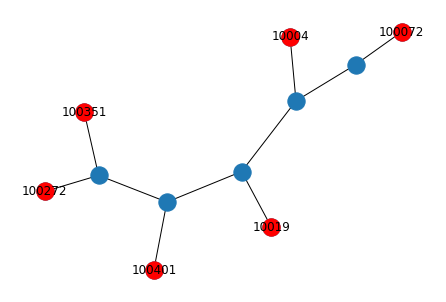

In [ ]:
# new_g = nx.Graph()
# new_g.add_edges_from(edgelist)
# layout = nx.spring_layout(new_g, seed=7)
# nx.draw(G=new_g, pos=layout, edge_color='black')

# labels = {}    
# for node in new_g.nodes():
#     if node in nodelist:
#         #set the node name as the key and the label as its value 
#         labels[node] = sample_ids[node]
# nx.draw_networkx_nodes(G=new_g, pos=layout, nodelist=nodelist, node_color='red')
# nx.draw_networkx_labels(G=new_g, pos=layout, labels=labels)
# plt.show()

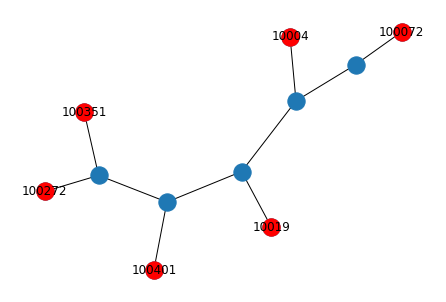

In [ ]:
# old_g = nx.Graph()
# old_g.add_edges_from(get_network_from_tree(Z, ind_to_id))
# layout = nx.spring_layout(old_g, seed=7)
# nx.draw(G=old_g, pos=layout, edge_color='black')

# labels = {}    
# for node in old_g.nodes():
#     if node in sample_ids:
#         #set the node name as the key and the label as its value 
#         labels[node] = node
# nx.draw_networkx_nodes(G=old_g, pos=layout, nodelist=sample_ids, node_color='red')
# nx.draw_networkx_labels(G=old_g, pos=layout, labels=labels)
# plt.show()

# WIP:

In [ ]:
vnc_meta.groupby('serialMotif').get_group('independent leg').hemilineage.value_counts()

hemilineage
13B            308
14A            271
12B            237
09A            210
21A            208
20A.22A        199
01B            186
19A            153
03A            150
13A            134
16B            132
15B            103
TBD             98
17A             92
01A             91
23B             89
04B             89
08A             64
24B.25B         48
20B.21B.22B     30
15A             24
03B             22
19B             20
26X             16
06B             16
17X.18X         13
00A             13
09B             12
14B             10
02A             10
10B              4
Name: count, dtype: int64

In [ ]:
vnc_meta.hemilineage.value_counts()

hemilineage
TBD            1600
20A.22A         806
07B             630
06A             603
19A             571
03A             570
04B             559
12B             549
09A             528
16B             510
14A             500
08B             496
03B             487
01B             485
06B             447
10B             442
23B             439
13B             430
19B             426
01A             413
13A             401
21A             388
17A             386
08A             351
05B             327
12A             319
02A             308
00A             257
09B             225
11A             191
18B             188
11B             174
15B             148
00B              58
27X              58
05A              52
24B.25B          48
17B              44
14B              39
20B.21B.22B      30
15A              24
26X              18
17X.18X          13
04A              12
21X               4
Name: count, dtype: int64

# MDS:
High stress: Not a great fit...

In [ ]:
M = 80

dist_df = msize_dist_df[M]
ind_to_id = [str(i) for i in n_ids]


In [ ]:
mds = manifold.MDS(
    n_components=2,
    random_state=1,
    dissimilarity="precomputed",
    n_jobs=1,
)

In [ ]:
dmat = squareform(dist_df.euclidean_distance.values)

In [ ]:
pos = mds.fit(dmat).embedding_
print(mds.stress_)
pos_dict = dict(zip(ind_to_id, pos))
label_to_id_dict = n_ids_meta.reset_index().groupby('type').bodyId.apply(list).to_dict()

211656684274.5397


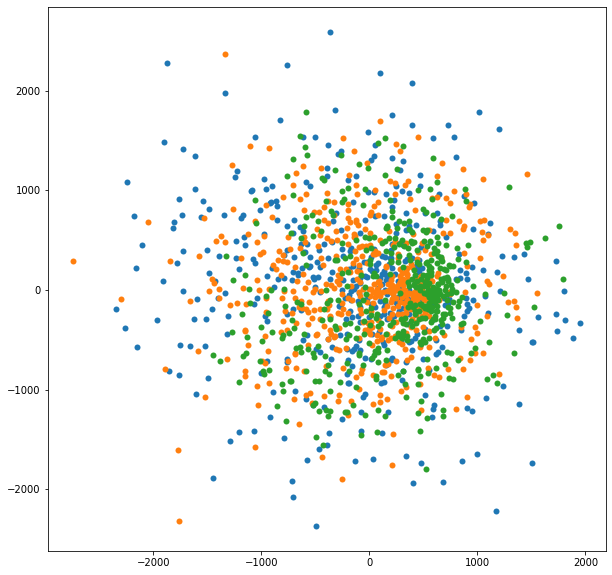

In [ ]:
plt.figure(figsize=(10,10))

colors = colors = cm.tab10.colors[:len(clusters)]


# for i, value in enumerate(label_to_id_dict.keys()):
    
#     coords = np.array([pos_dict[j] for j in label_to_id_dict[value]])

#     plt.scatter(coords[:, 0], coords[:, 1], color=colors[i], lw=0, label="MDS")
for ind, c in enumerate(clusters):
    
    coords = np.array([pos_dict[j] for j in c])

    plt.scatter(coords[:, 0], coords[:, 1], color=colors[ind], lw=0, label="MDS")
    
    
label_dict = n_ids_meta['type'].to_dict()
ind_to_label = [label_dict.get(i) for i in ind_to_id]    
# label_point(pos[:, 0], pos[:, 1], ind_to_label, plt.gca())  

texts = list(plt.gca().texts)

adjust_text(texts,expand=(1.2, 1.5), min_arrow_len=10, arrowprops=dict(linewidth=2, arrowstyle='->', color='#e2102233'))
# plt.savefig(f'./figures/VNC/09_hemiprep/{datadate}_smallhemis1_M{M}_wem_wd_seq_indleg_MDS.pdf')

# Spectral embedding:WIP

In [ ]:
n_neighbors = 12  # neighborhood which is used to recover the locally linear structure
n_components = 2  # number of coordinates for the manifold
spectral = manifold.SpectralEmbedding(

    n_components=n_components, n_neighbors=n_neighbors, random_state=42
)

In [ ]:
# plt.rcParams['text.latex.preamble'] = r"\usepackage{color} \usepackage{amsmath}"

In [ ]:
# plt.figure()
# plt.ylabel(r'\textcolor{red}{Today} '+
#            r'\textcolor{green}{is} '+
#            r'\textcolor{blue}{cloudy.}')
# plt.savefig("test.pdf")

# Cluster evaluation using L/R

In [ ]:
ids_meta = vnc_meta[vnc_meta['bodyId'].isin(ind_to_id)].copy(True)

ids_meta['side'] = ids_meta.instance.str.split('_').dropna().apply(lambda x: x[-1])

4        L
14       R
81       L
89       R
124      L
        ..
22621    R
22622    R
22756    R
22811    L
22823    L
Name: instance, Length: 1369, dtype: object

In [ ]:
vnc_meta.instance.str.split('_').dropna().apply(lambda x: x[-1])

0        TBD
1          R
2        TBD
3          L
4          L
        ... 
23388    TBD
23389      R
23390      L
23391      L
23392      R
Name: instance, Length: 23392, dtype: object

In [ ]:
vnc_meta[vnc_meta['bodyId'].isin(ind_to_id)]

0

In [ ]:
ids_lrctype_list = vnc_meta[vnc_meta['bodyId'].isin(ind_to_id)].groupby(['type', 'somaSide']).bodyId.apply(list)

In [ ]:
ids_lrctype_list.apply(len).sort_values().value_counts()

bodyId
1    235
3    207
2    117
4     38
5     14
6      6
7      3
Name: count, dtype: int64

In [ ]:
len([(key, val) for key, val in ctype_to_leaf.items() if len(val)==4])

42

In [ ]:
lr_ctype_to_leaf = vnc_meta[vnc_meta['bodyId'].isin(ind_to_id)].groupby('type').bodyId.apply(list).to_dict()

In [ ]:
# stats_df = get_clustering_stats(Z=Z, ctype_to_id=ctype_to_leaf, ind_to_id=ind_to_id)
fname = f'./data/vnc/{datadate}_data/gmatching/cluster_analysis/M{M}_hemisample_extrametrics.parquet'
# stats_df.to_parquet(fname)


# Clustering of hemilineages individually or as a group? 

In [ ]:
hemiexample = ['13B']

In [ ]:
hemiexample_ids = list(set(vnc_meta[(vnc_meta['hemilineage'].isin(hemiexample))].bodyId.values)) # the integers have the numpy.int64 datatype!
hemiexample_ids = sorted([str(i) for i in hemiexample_ids])[:]
len(hemiexample_ids)

430

In [ ]:
hemiexample_ids_meta = vnc_meta[vnc_meta['bodyId'].isin(hemiexample_ids)].copy(True).set_index('bodyId')
hemiexample_ids_meta.index = hemiexample_ids_meta.index.astype('str')
# hemiexample_ids_ptn = get_neighbourhood(Ids=hemiexample_ids, df=vnc_edges)
# hemiexample_ids_pp_set = set(hemiexample_ids_ptn[['pre', 'post']].to_numpy().flatten())
# hemiexample_ids_nhood = vnc_edges[vnc_edges['post'].isin(hemiexample_ids_pp_set) & vnc_edges['pre'].isin(hemiexample_ids_pp_set)].sort_index().copy(True)


In [ ]:
hemisample_M15_ew_dist_df = hemis_M15_ew_dist_df[(hemis_M15_ew_dist_df['id_1'].isin(hemiexample_ids))&(hemis_M15_ew_dist_df['id_2'].isin(hemiexample_ids))]

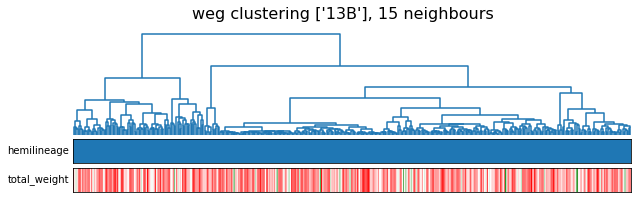

In [ ]:
M=15
dist_df = hemisample_M15_ew_dist_df

dist_type = 'euclidean_distance'

method='ward'

cond_dist = (dist_df[dist_type].values)
Z = linkage(cond_dist, method=method) ####### linkage

ind_to_id = [str(i) for i in hemiexample_ids]
title = f'{hemiexample}, M ={M}, {dist_type}, method={method}'

N_type_data= 2

hemi_ind = hemiexample_ids_meta.loc[hemiexample_ids]['hemilineage'].to_numpy()
hemi_uniques = list(set(hemi_ind))
numeric_hemi_data = np.zeros_like(hemi_ind, dtype=int)
for i, category in enumerate(hemi_uniques):
    numeric_hemi_data[hemi_ind == category] = i

cinds_avoid_rg =list(range(len(hemi_uniques))) # list(range(len(hemi_uniques)+2))[:2] + list(range(len(hemi_uniques)+2))[4:]  # #
colors = [cm.tab10.colors[cind] for cind in cinds_avoid_rg]

# colors = ['blue', 'orange', 'pink']
# Create a colormap from the colors
hemicmap = plt.matplotlib.colors.ListedColormap(colors)

# Plot the categorical data
# method = 'ward'


fig = plt.figure(figsize=(10, 3))
fig.suptitle(f'weg clustering {hemiexample}, {M} neighbours', fontsize=16)

gs0 = matplotlib.gridspec.GridSpec(2,1, figure=fig,
                                   height_ratios=[10,5], hspace=0.05)
gs1 = matplotlib.gridspec.GridSpecFromSubplotSpec(2,1, subplot_spec=gs0[0],
                                                  height_ratios=[1,0],
                                                  hspace=0)

ax_col_dendrogram = fig.add_subplot(gs1[0])

col_dendrogram = scipy.cluster.hierarchy.dendrogram(Z, ax=ax_col_dendrogram, color_threshold=0)
ax_col_dendrogram.set_axis_off()

xind = col_dendrogram['leaves']

xmin,xmax = ax_col_dendrogram.get_xlim()

gs2 = matplotlib.gridspec.GridSpecFromSubplotSpec(N_type_data, 1, subplot_spec=gs0[1])

n_ids_cumweight_df = nM_stats[M]
type_data=zip([numeric_hemi_data, n_ids_cumweight_df.total_weight.to_numpy()],[hemicmap, wcmap], ['hemilineage', 'total_weight']) 

for i,(data,cmap, label) in enumerate(type_data):
    ax = fig.add_subplot(gs2[i], sharex=ax_col_dendrogram)
    ax.imshow(data[xind].reshape((1,-1)), aspect='auto', extent=[xmin,xmax,0,1], cmap=cmap)
    ax.set_yticks([])
    ax.set_ylabel(label, rotation=0, ha='right', va='center')
    ax.set_xticks([])
    plt.setp(ax.get_xticklabels(), visible=False)
save=False
if save:

    plt.savefig(f'./figures/VNC/{datadate}/10_open_hemi_runs/{datadate}_weg_hemisample_M{M}_topview.png', bbox_inches='tight', dpi=200, transparent=True)
save=False

In [ ]:
hemisample_M15_ew_dist_df

In [ ]:
M=15
dist_df = hemisample_M15_ew_dist_df

dist_type = 'euclidean_distance'

method='ward'

cond_dist = (dist_df[dist_type].values)
Z = linkage(cond_dist, method=method) ####### linkage
hemiexample_ind_to_id = [str(i) for i in hemiexample_ids]


In [ ]:
hemiexample_ctype_to_leaf = vnc_meta[vnc_meta['bodyId'].isin(hemiexample_ind_to_id)].groupby('type').bodyId.apply(list).to_dict()

In [ ]:
stats_df = get_clustering_stats(Z=Z, ctype_to_id=hemiexample_ctype_to_leaf, ind_to_id=hemiexample_ind_to_id)
# fname = f'./data/vnc/{datadate}_data/gmatching/cluster_analysis/M{M}_hemisample_extrametrics.parquet'
# stats_df.to_parquet(fname)


In [ ]:
stats_df['lps_frac'] =  (stats_df['len'] * stats_df['lps']).astype(int).astype(str)+ '/' + stats_df['len'].astype(int).astype(str) 

In [ ]:
M15_sample_pct_df= (stats_df[stats_df['lps']==1])
print('number of cell types perfectly clustered:', len(M15_sample_pct_df))
print('number of neurons in perfect clusters:', M15_sample_pct_df.len.sum())

number of cell types perfectly clustered: 11
number of neurons in perfect clusters: 44


In [ ]:
M15_sample_rct_df = stats_df[(stats_df['lps']<1)&(stats_df['lps']>=0.5)&(stats_df['len']>2)]
print('number of cell types reasonably clustered:', len(M15_sample_rct_df))
print('number of neurons in reasonable clusters 1>LPS>0.5:', M15_sample_rct_df.len.sum())

number of cell types reasonably clustered: 18
number of neurons in reasonable clusters 1>LPS>0.5: 105


In [ ]:
M15_sample_bct_df = stats_df[((stats_df['lps']<.5)&(stats_df['len']>2))|((stats_df['lps']==.5)&(stats_df['len']==2))]
print('number of cell types in bad clusters 0.5>LPS:', len(M15_sample_bct_df))
print('number of neurons in bad clusters 0.5>LPS:', M15_sample_bct_df.len.sum())

number of cell types in bad clusters 0.5>LPS: 64
number of neurons in bad clusters 0.5>LPS: 274


In [ ]:
stats_df.m_p.sum()

202

In [ ]:
stats_df.m_p.sum()/stats_df.len.sum()

0.47754137115839246

In [ ]:
hemicoverages_list = []
for hemiexample in heminames:
    hemiexample_ids = list(set(vnc_meta[(vnc_meta['hemilineage'].isin([hemiexample]))].bodyId.values)) # the integers have the numpy.int64 datatype!
    hemiexample_ids = sorted([str(i) for i in hemiexample_ids])[:]
    len(hemiexample_ids)

    Ms = [15, 30, 50, 80, 100]
    dist_type = 'euclidean_distance'
    method='ward'
    hemiexample_ind_to_id = [str(i) for i in hemiexample_ids]
    hemiexample_ctype_to_leaf = vnc_meta[vnc_meta['bodyId'].isin(hemiexample_ind_to_id)].groupby('type').bodyId.apply(list).to_dict()
    coverages=[]

    for M in Ms:
        dist_df = msize_dist_df[M]
        hemisample_dist_df = dist_df[(dist_df['id_1'].isin(hemiexample_ids))&(dist_df['id_2'].isin(hemiexample_ids))]
        cond_dist = (hemisample_dist_df[dist_type].values)
        Z = linkage(cond_dist, method=method) ####### linkage
        stats_df = get_clustering_stats(Z=Z, ctype_to_id=hemiexample_ctype_to_leaf, ind_to_id=hemiexample_ind_to_id)
        purity_coverage = stats_df.m_p.sum()/stats_df.len.sum()
        coverages.append(purity_coverage)
    hemicoverages_list.append(coverages)



In [ ]:
stats_df

,labels,len,lps,mpd,pam,n_p,m_p,s_p
0,AN14A003,6,0.666667,5.200000,0.176471,2,6,0
1,IN14A001,6,1.000000,4.133333,1.000000,1,6,0
2,IN14A002,6,1.000000,4.133333,1.000000,1,6,0
3,IN14A004,6,1.000000,4.133333,1.000000,1,6,0
4,IN14A005,6,1.000000,4.133333,1.000000,1,6,0
...,...,...,...,...,...,...,...,...
113,IN14A118,6,0.166667,9.666667,0.045455,0,0,6
114,IN14A119,6,0.333333,18.933333,0.015789,1,2,4
115,IN14A120,6,0.166667,12.266667,0.045455,0,0,6
116,IN14A121,3,0.666667,4.666667,0.272727,1,2,1


(0.39, 0.64)

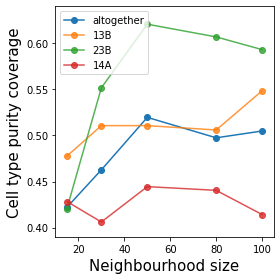

In [ ]:
plt.figure(figsize=(4,4))
plt.plot(Ms, ct_cov_vals, 'o-', label='altogether')
for index, hemiexample in enumerate(heminames):
    plt.plot(Ms, hemicoverages_list[index], 'o-', alpha=0.8, label=hemiexample)
plt.legend()
plt.xlabel('Neighbourhood size', size=15)
plt.ylabel('Cell type purity coverage', size=15)
plt.tight_layout()
plt.xlim([10,105])
plt.ylim([0.39, 0.64])

(0.39, 0.64)

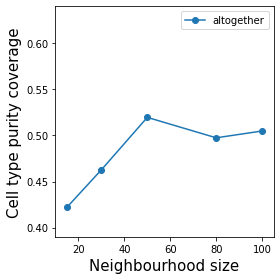

In [ ]:
plt.figure(figsize=(4,4))
plt.plot(Ms, ct_cov_vals, 'o-', label='altogether')
# for index, hemiexample in enumerate(heminames):
#     plt.plot(Ms, hemicoverages_list[index], 'o-', alpha=0.8, label=hemiexample)
plt.legend()
plt.xlabel('Neighbourhood size', size=15)
plt.ylabel('Cell type purity coverage', size=15)
plt.tight_layout()
plt.xlim([10,105])
plt.ylim([0.39, 0.64])

In [ ]:
Ms = [15, 30,50,80,100]
Ms_hemi_ct_stat_vals=[]
for hemi in heminames:
    hemi_tab = all_q_df[all_q_df['hemi']==hemi]
    ct_stat_vals = []
    for i in Ms:  
        ct_stat = hemi_tab[hemi_tab['M']==i].m_p.sum()/hemi_tab[hemi_tab['M']==i].len.sum()
        ct_stat_vals.append(ct_stat)
    Ms_hemi_ct_stat_vals.append(ct_stat_vals)

(0.38, 0.63)

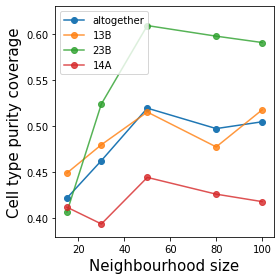

In [ ]:
plt.figure(figsize=(4,4))
plt.plot(Ms, ct_cov_vals, 'o-', label='altogether')
for index, hemiexample in enumerate(heminames):
    plt.plot(Ms, Ms_hemi_ct_stat_vals[index], 'o-', alpha=0.8, label=hemiexample)
plt.legend()
plt.xlabel('Neighbourhood size', size=15)
plt.ylabel('Cell type purity coverage', size=15)
plt.tight_layout()
plt.xlim([10,105])
plt.ylim([0.38, 0.63])

(0.38, 0.63)

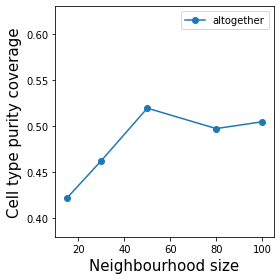

In [ ]:
plt.figure(figsize=(4,4))
plt.plot(Ms, ct_cov_vals, 'o-', label='altogether')
# for index, hemiexample in enumerate(heminames):
#     plt.plot(Ms, Ms_hemi_ct_stat_vals[index], 'o-', alpha=0.8, label=hemiexample)
plt.legend()
plt.xlabel('Neighbourhood size', size=15)
plt.ylabel('Cell type purity coverage', size=15)
plt.tight_layout()
plt.xlim([10,105])
plt.ylim([0.38, 0.63])

In [ ]:
Ms_hemi_ct_stat_vals

[[0.5048041389504804,
  0.5048041389504804,
  0.5048041389504804,
  0.5048041389504804,
  0.5048041389504804],
 [0.5048041389504804,
  0.5048041389504804,
  0.5048041389504804,
  0.5048041389504804,
  0.5048041389504804],
 [0.5048041389504804,
  0.5048041389504804,
  0.5048041389504804,
  0.5048041389504804,
  0.5048041389504804]]